# Time series

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from scipy import signal
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

from pathlib import Path

import os, sys
sys.path.insert(0, os.path.abspath('../src'))

from ts import *
from utils import *

In [2]:
data_path = "../data"

In [3]:
DataDownloader(data_path).download_all_csv()

In [4]:
covidpro_df, dpc_regioni_df, _, _, _ = load_data(data_path)

## Exploration TS: infected Firenze

In [5]:
province = "Firenze"
compart = "New_cases"
date = 'Date'

In [6]:
tmp_df = covidpro_df[covidpro_df.Province == province]

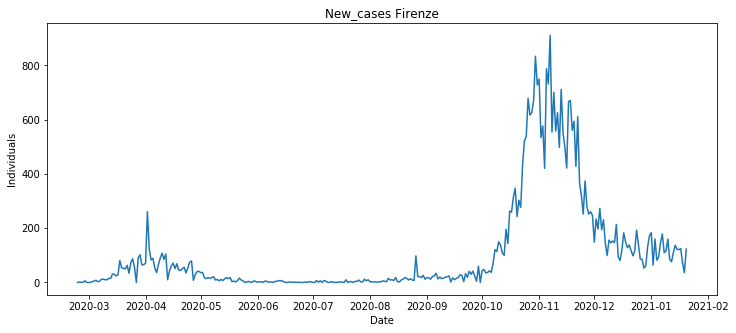

In [7]:
visualize_ts(tmp_df, date, compart, province)

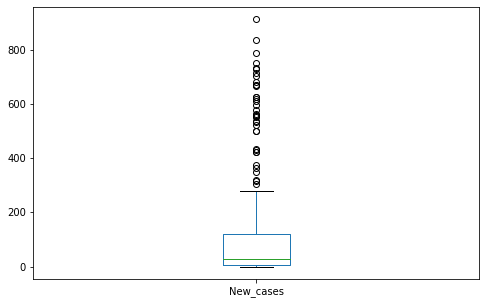

In [8]:
show_boxplot(tmp_df, compart)

In [9]:
tmp_df = tmp_df.set_index(date)

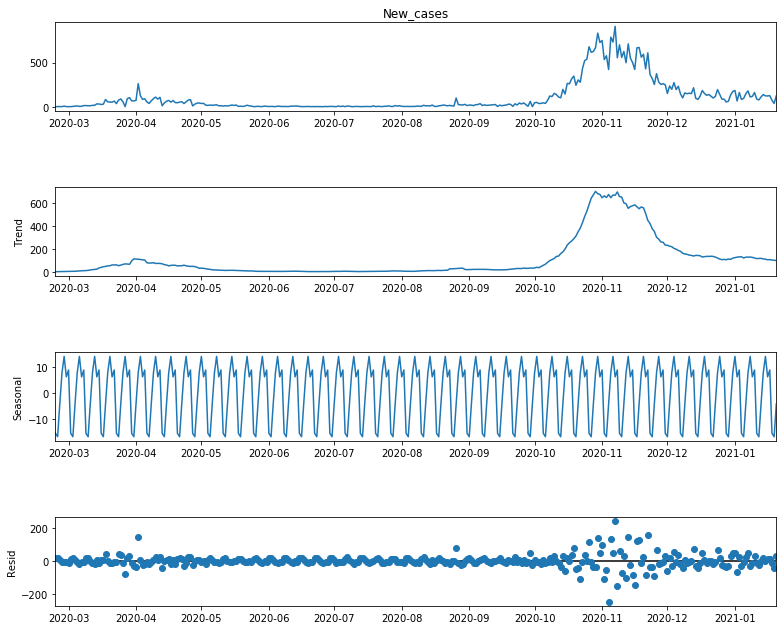

In [10]:
# Additive Decomposition
plot_decomposition(tmp_df, compart)

In [11]:
# Test for stationarity
adf_test(tmp_df[compart].values)

ADF Statistic: -3.0623944710556987
p-value: 0.029464257418658487
Critical Values:
   1%, -3.4512146067362317
Critical Values:
   5%, -2.870730188960711
Critical Values:
   10%, -2.5716664849383113


In [12]:
# Test for trend stationarity
kpss_test(tmp_df[compart].values)


KPSS Statistic: 0.659024
p-value: 0.017271
Critical Values:
   10%, 0.347
Critical Values:
   5%, 0.463
Critical Values:
   2.5%, 0.574
Critical Values:
   1%, 0.739


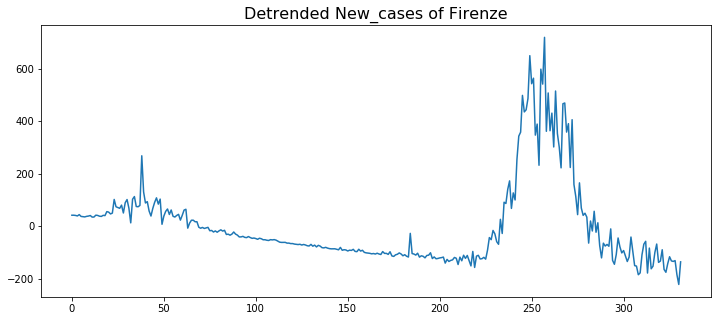

In [13]:
# Detrend by subtracting best leastsq fit
plot_detrended_deseason(
    signal.detrend(tmp_df[compart].values), 
    province,
    compart,
    "Detrended")

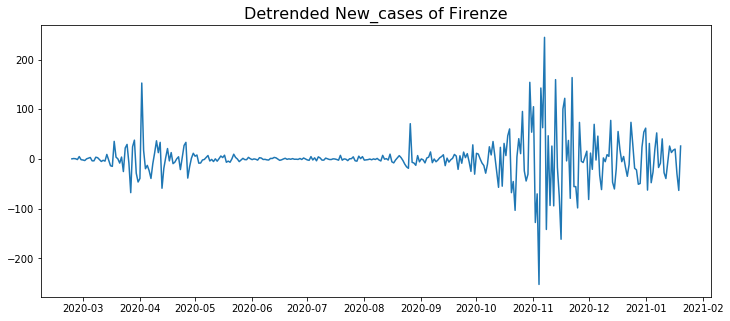

In [14]:
# Detrend by subtracting trend comp
plot_detrended_deseason(
    remove_trend(tmp_df, compart), 
    province,
    compart,
    "Detrended")

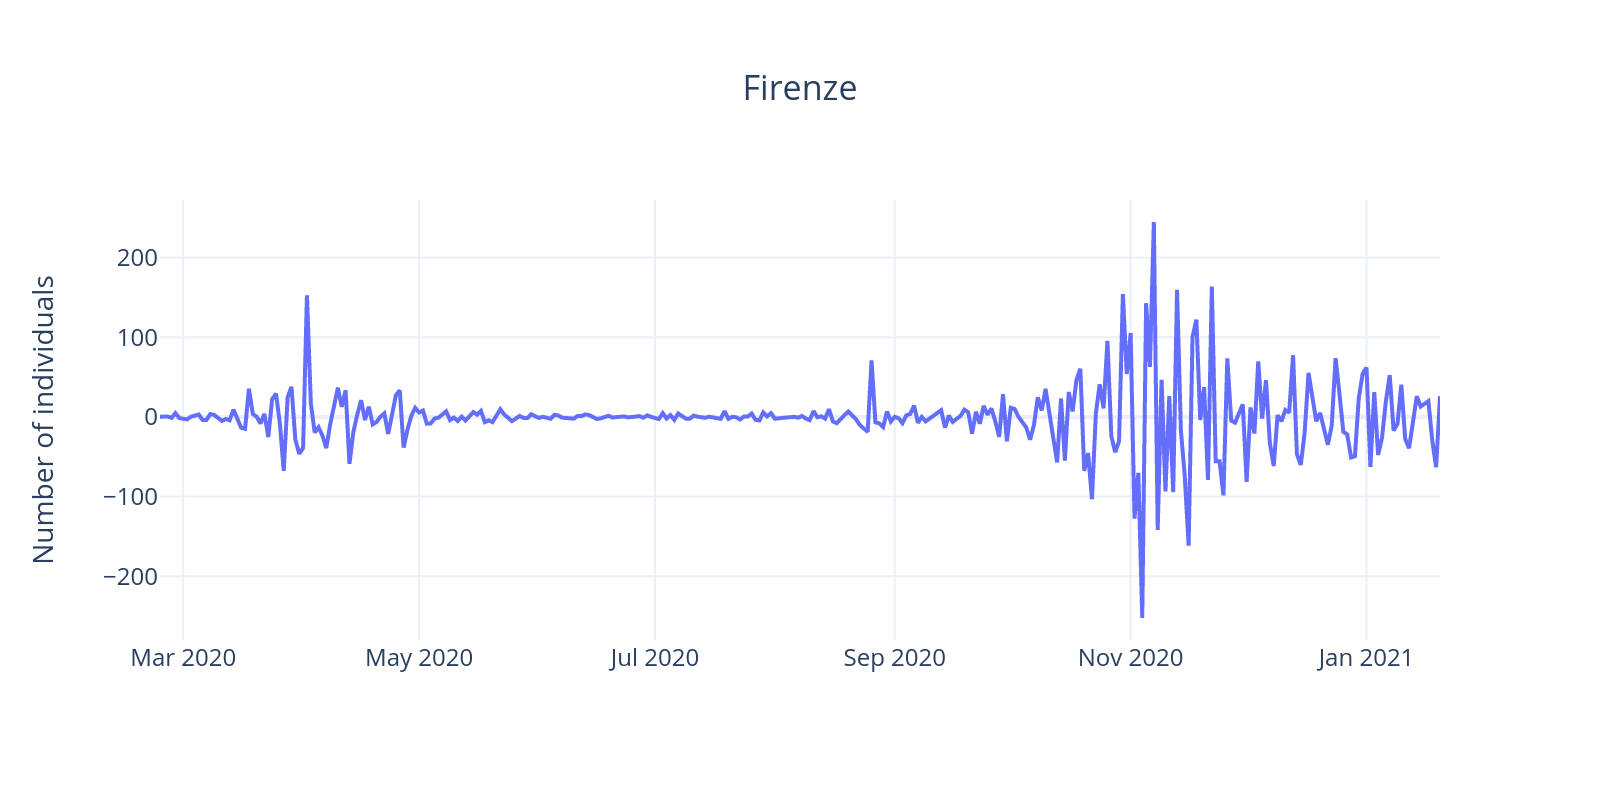

In [15]:
plot_detrended_deseason_plotly(
    remove_trend(tmp_df, compart), 
    province,
    compart,
    "Detrended")

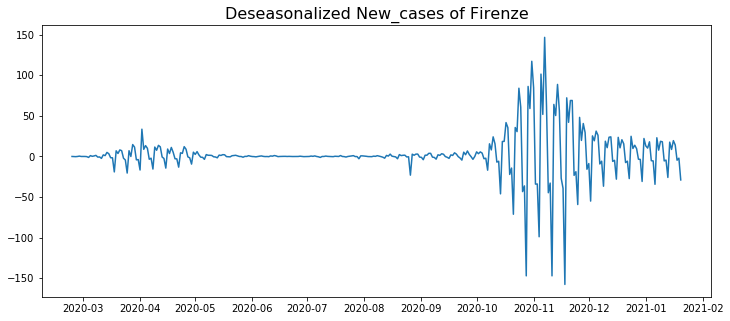

In [16]:
# Deseasonalize by subtracting trend
plot_detrended_deseason(
    deseason_trend(tmp_df, compart), 
    province,
    compart,
    "Deseasonalized")

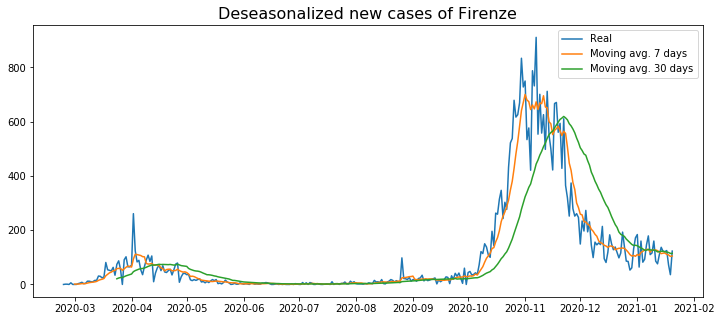

In [17]:
# Deseasonalize by taking mov. avg. with length = seasonal window
plot_deseason_ma(tmp_df, compart, province)

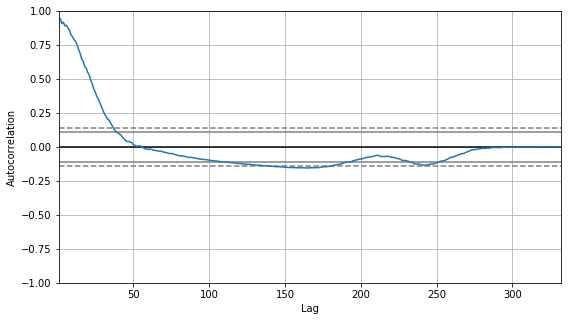

In [18]:
# Seasonality test
plot_autocorr(tmp_df, compart)

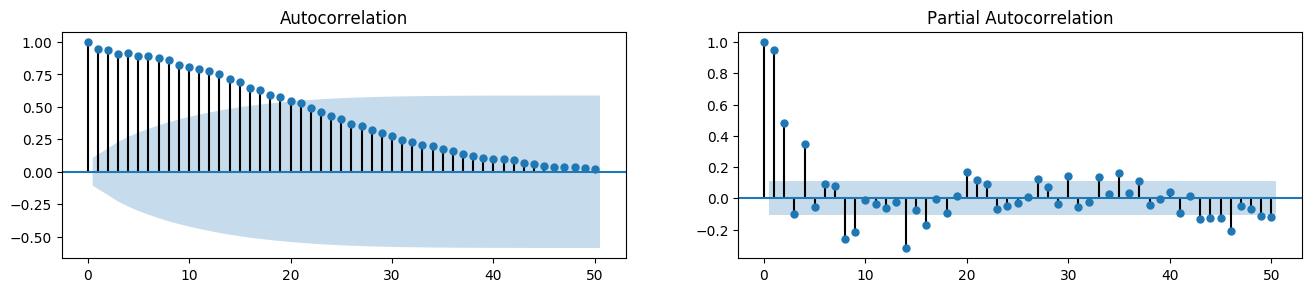

In [19]:
# Autocorrelation and partial autocorrelation
plot_acf_pacf(tmp_df, compart)

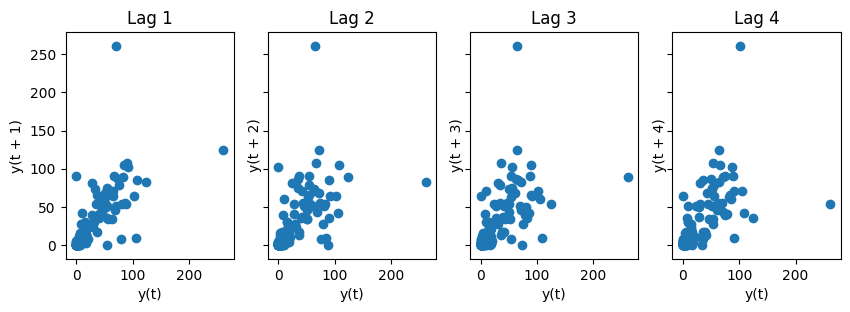

In [31]:
"""
Lag plots:
If points get wide and scattered with increasing lag, 
this means lesser correlation
"""

plot_lag_plots(tmp_df.query("20200701 > Date"), compart)

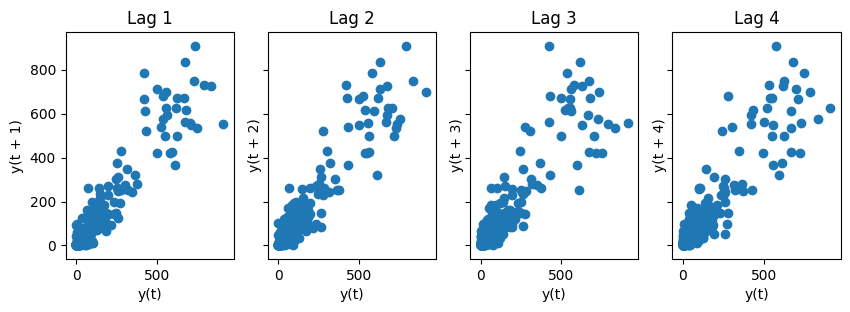

In [32]:
plot_lag_plots(tmp_df, compart)

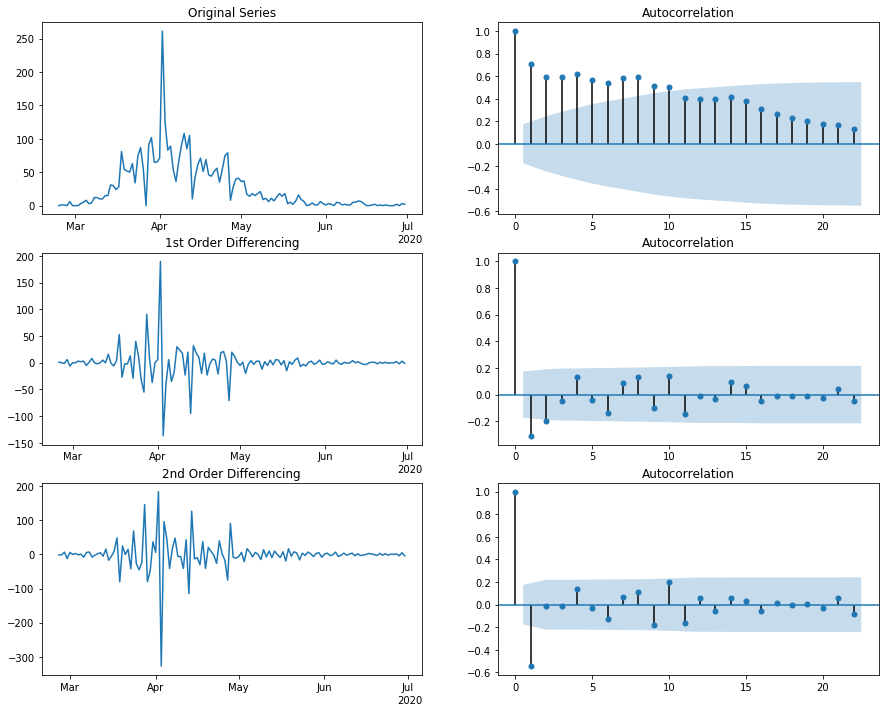

In [37]:
# Original Series
fig, axes = plt.subplots(3, 2, figsize=(15,12))
locator = mdates.AutoDateLocator(minticks=3)
formatter = mdates.ConciseDateFormatter(locator)
axes[0, 0].xaxis.set_major_locator(locator)
axes[0, 0].xaxis.set_major_formatter(formatter)
axes[1, 0].xaxis.set_major_locator(locator)
axes[1, 0].xaxis.set_major_formatter(formatter)
axes[2, 0].xaxis.set_major_locator(locator)
axes[2, 0].xaxis.set_major_formatter(formatter)

axes[0, 0].plot(tmp_df.query("20200701 > Date")[compart])
axes[0, 0].set_title('Original Series')
plot_acf(tmp_df.query("20200701 > Date")[compart], ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(tmp_df.query("20200701 > Date")[compart].diff())
axes[1, 0].set_title('1st Order Differencing')
plot_acf(tmp_df.query("20200701 > Date")[compart].diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(tmp_df.query("20200701 > Date")[compart].diff().diff())
axes[2, 0].set_title('2nd Order Differencing')
plot_acf(tmp_df.query("20200701 > Date")[compart].diff().diff().dropna(), ax=axes[2, 1])

plt.show()

In [20]:
# Estimate forecastability
print("SampEn:", SampEn(tmp_df[compart].values, m=2, r=0.2*np.std(tmp_df[compart].values)))
print("ApproxEn:", ApEn(tmp_df[compart].values, m=2, r=0.2*np.std(tmp_df[compart].values))) 

SampEn: 0.08969363102750517
ApproxEn: 0.24777649675081914


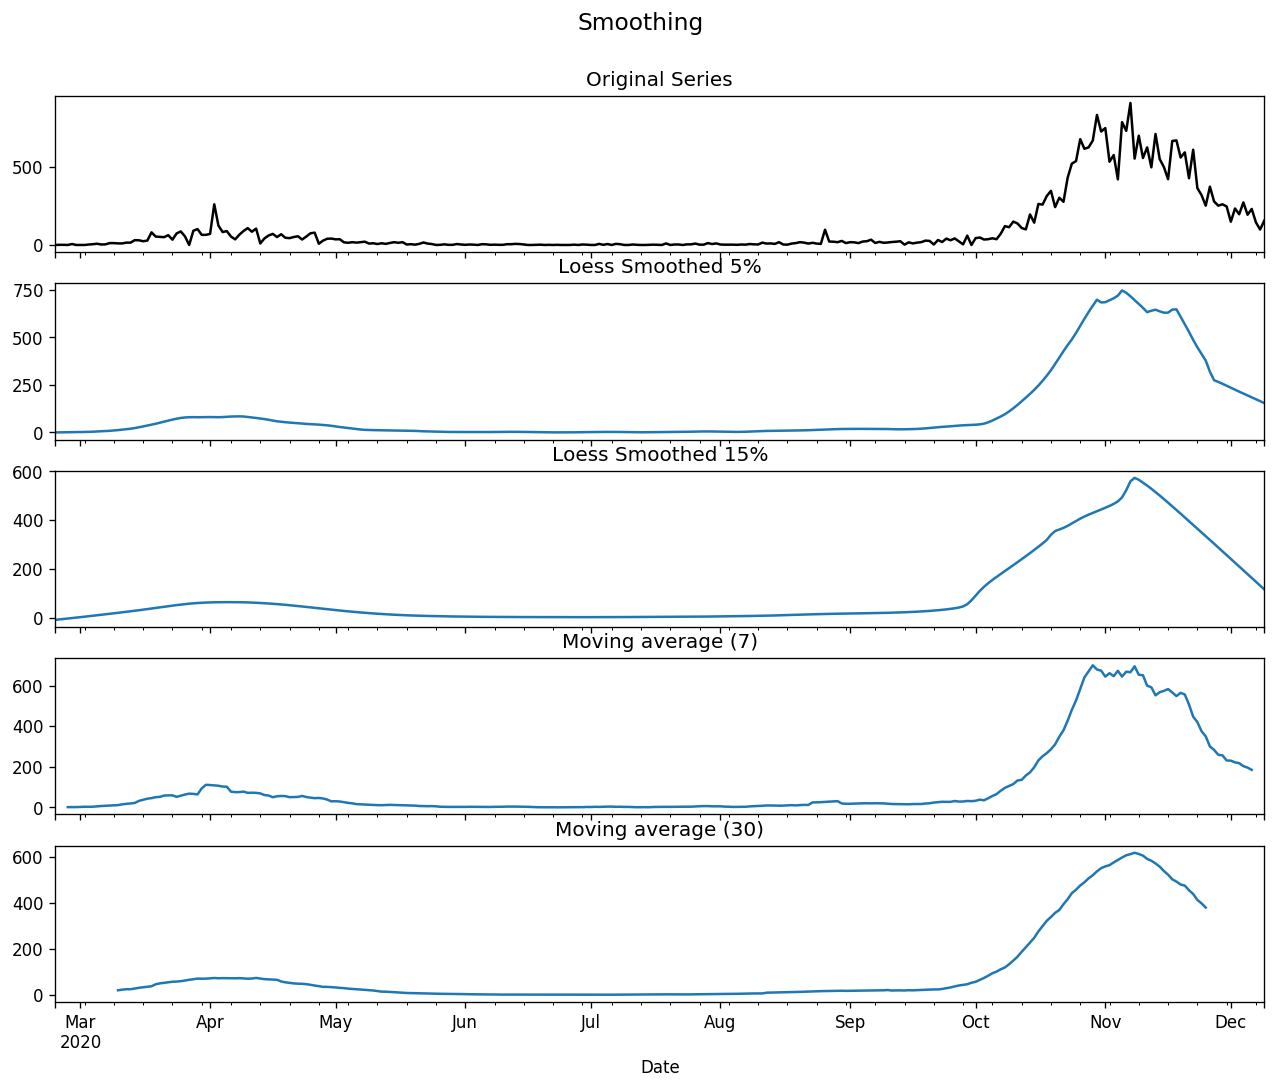

In [21]:
# Smoothing
plot_smoothing(tmp_df, compart)

In [22]:
"""
Granger causality tests:

Infected - Month
Infected - Deaths
"""

tmp_df = covidpro_df[covidpro_df.Province == province]

tmp_df['month'] = tmp_df[date].dt.month
gc_res = grangercausalitytests(tmp_df[[compart, 'month']], maxlag=3)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.0126  , p=0.0837  , df_denom=286, df_num=1
ssr based chi2 test:   chi2=3.0442  , p=0.0810  , df=1
likelihood ratio test: chi2=3.0282  , p=0.0818  , df=1
parameter F test:         F=3.0126  , p=0.0837  , df_denom=286, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.3696  , p=0.6914  , df_denom=283, df_num=2
ssr based chi2 test:   chi2=0.7522  , p=0.6865  , df=2
likelihood ratio test: chi2=0.7512  , p=0.6869  , df=2
parameter F test:         F=0.3696  , p=0.6914  , df_denom=283, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.6856  , p=0.5615  , df_denom=280, df_num=3
ssr based chi2 test:   chi2=2.1082  , p=0.5502  , df=3
likelihood ratio test: chi2=2.1005  , p=0.5518  , df=3
parameter F test:         F=0.6856  , p=0.5615  , df_denom=280, df_num=3


In [23]:
gc_res = grangercausalitytests(tmp_df[[compart, 'Deaths']], maxlag=3)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.7995  , p=0.3720  , df_denom=286, df_num=1
ssr based chi2 test:   chi2=0.8079  , p=0.3688  , df=1
likelihood ratio test: chi2=0.8067  , p=0.3691  , df=1
parameter F test:         F=0.7995  , p=0.3720  , df_denom=286, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.5788  , p=0.0776  , df_denom=283, df_num=2
ssr based chi2 test:   chi2=5.2488  , p=0.0725  , df=2
likelihood ratio test: chi2=5.2015  , p=0.0742  , df=2
parameter F test:         F=2.5788  , p=0.0776  , df_denom=283, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.2330  , p=0.2980  , df_denom=280, df_num=3
ssr based chi2 test:   chi2=3.7915  , p=0.2849  , df=3
likelihood ratio test: chi2=3.7666  , p=0.2878  , df=3
parameter F test:         F=1.2330  , p=0.2980  , df_denom=280, df_num=3


## Exploration TS: deaths Firenze

In [24]:
province = "Firenze"
compart = "Deaths"
date = 'Date'

In [25]:
tmp_df = covidpro_df[covidpro_df.Province == province]

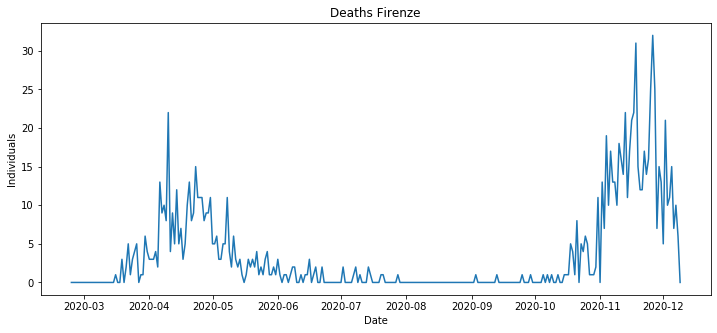

In [26]:
visualize_ts(tmp_df, date, compart, province)

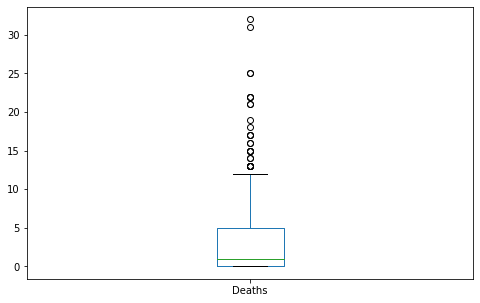

In [27]:
show_boxplot(tmp_df, compart)

In [28]:
tmp_df = tmp_df.set_index(date)

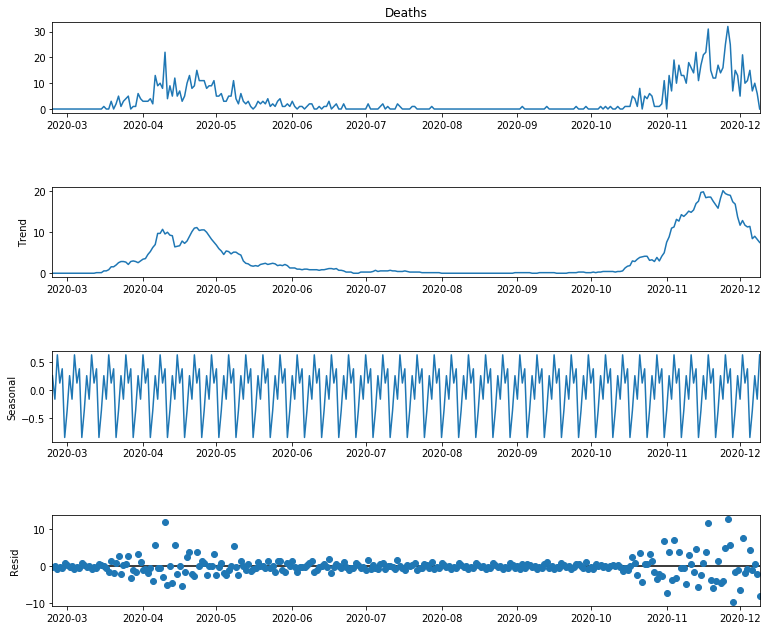

In [29]:
# Additive Decomposition
plot_decomposition(tmp_df, compart)

In [30]:
# Test for stationarity
adf_test(tmp_df[compart].values)

ADF Statistic: -2.7519413702967155
p-value: 0.06547326647232678
Critial Values:
   1%, -3.45453261164607
Critial Values:
   5%, -2.8721859575020017
Critial Values:
   10%, -2.572442854861866


In [31]:
# Test for trend stationarity
kpss_test(tmp_df[compart].values)


KPSS Statistic: 0.365743
p-value: 0.091921
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


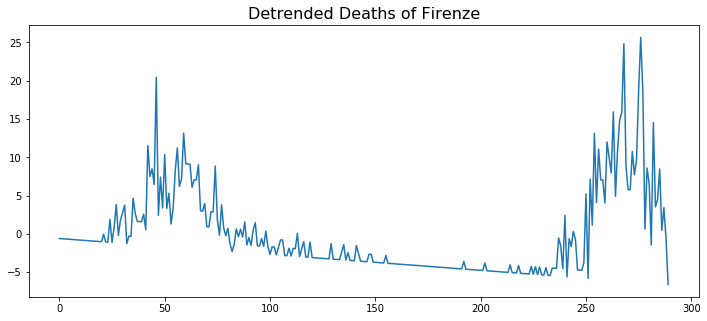

In [32]:
# Detrend by subtracting best leastsq fit
plot_detrended_deseason(
    signal.detrend(tmp_df[compart].values), 
    province,
    compart,
    "Detrended")

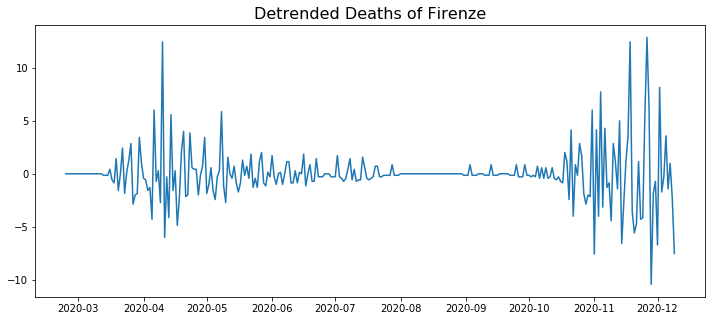

In [33]:
# Detrend by subtracting trend comp
plot_detrended_deseason(
    remove_trend(tmp_df, compart), 
    province,
    compart,
    "Detrended")

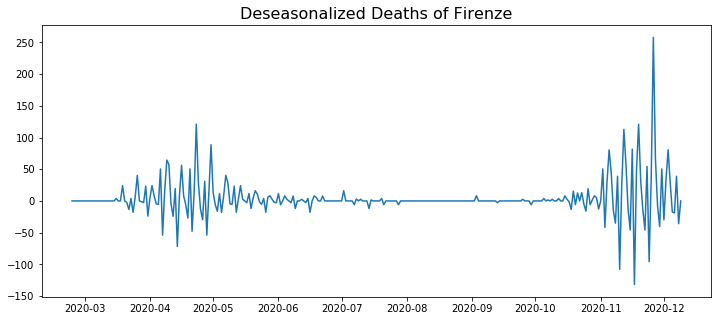

In [34]:
# Deseasonalize by subtracting trend
plot_detrended_deseason(
    deseason_trend(tmp_df, compart), 
    province,
    compart,
    "Deseasonalized")

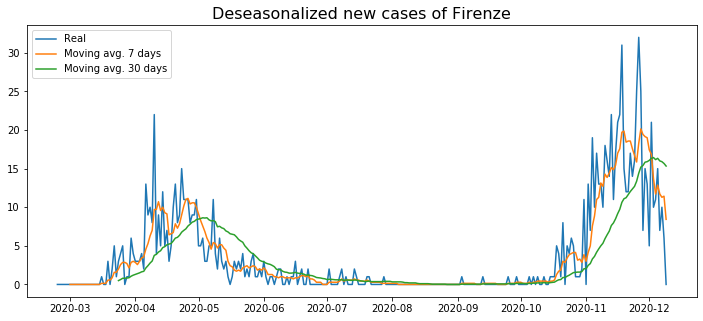

In [35]:
# Deseasonalize by taking mov. avg. with length = seasonal window
plot_deseason_ma(tmp_df, compart, province)

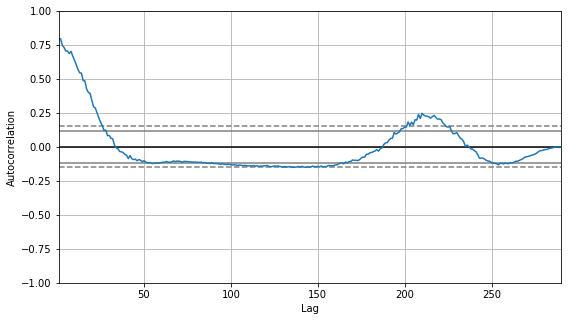

In [36]:
# Seasonality test
plot_autocorr(tmp_df, compart)

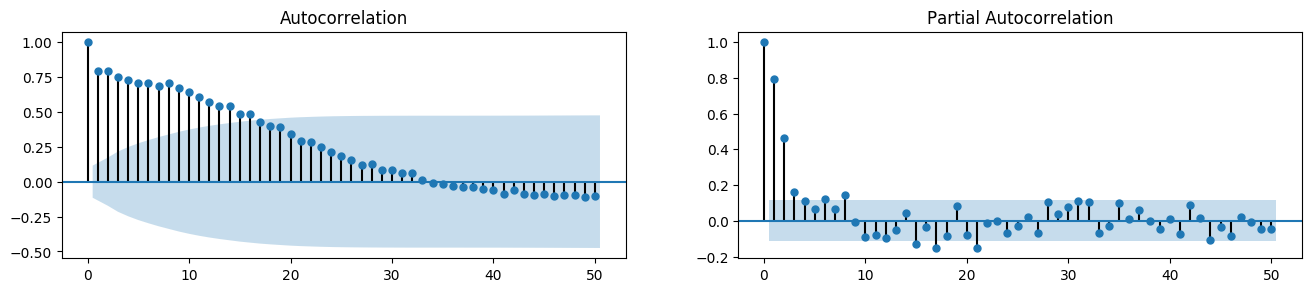

In [37]:
# Autocorrelation and partial autocorrelation
plot_acf_pacf(tmp_df, compart)

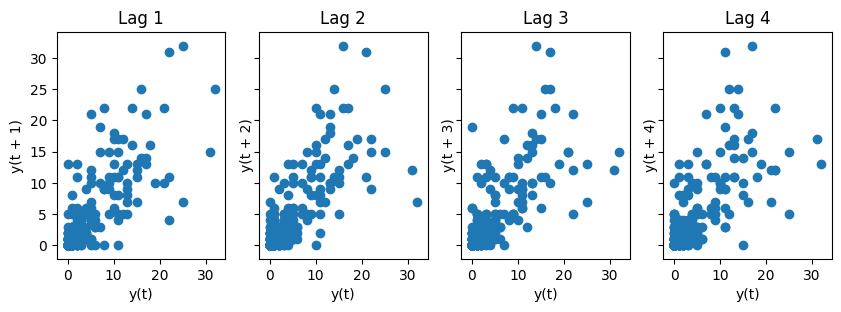

In [38]:
"""
Lag plots:
If points get wide and scattered with increasing lag, 
this means lesser correlation
"""

plot_lag_plots(tmp_df, compart)

In [39]:
# Estimate forecastability
print("SampEn:", SampEn(tmp_df[compart].values, m=2, r=0.2*np.std(tmp_df[compart].values)))
print("ApproxEn:", ApEn(tmp_df[compart].values, m=2, r=0.2*np.std(tmp_df[compart].values))) 

SampEn: 0.18732204802912877
ApproxEn: 0.47577134095104867


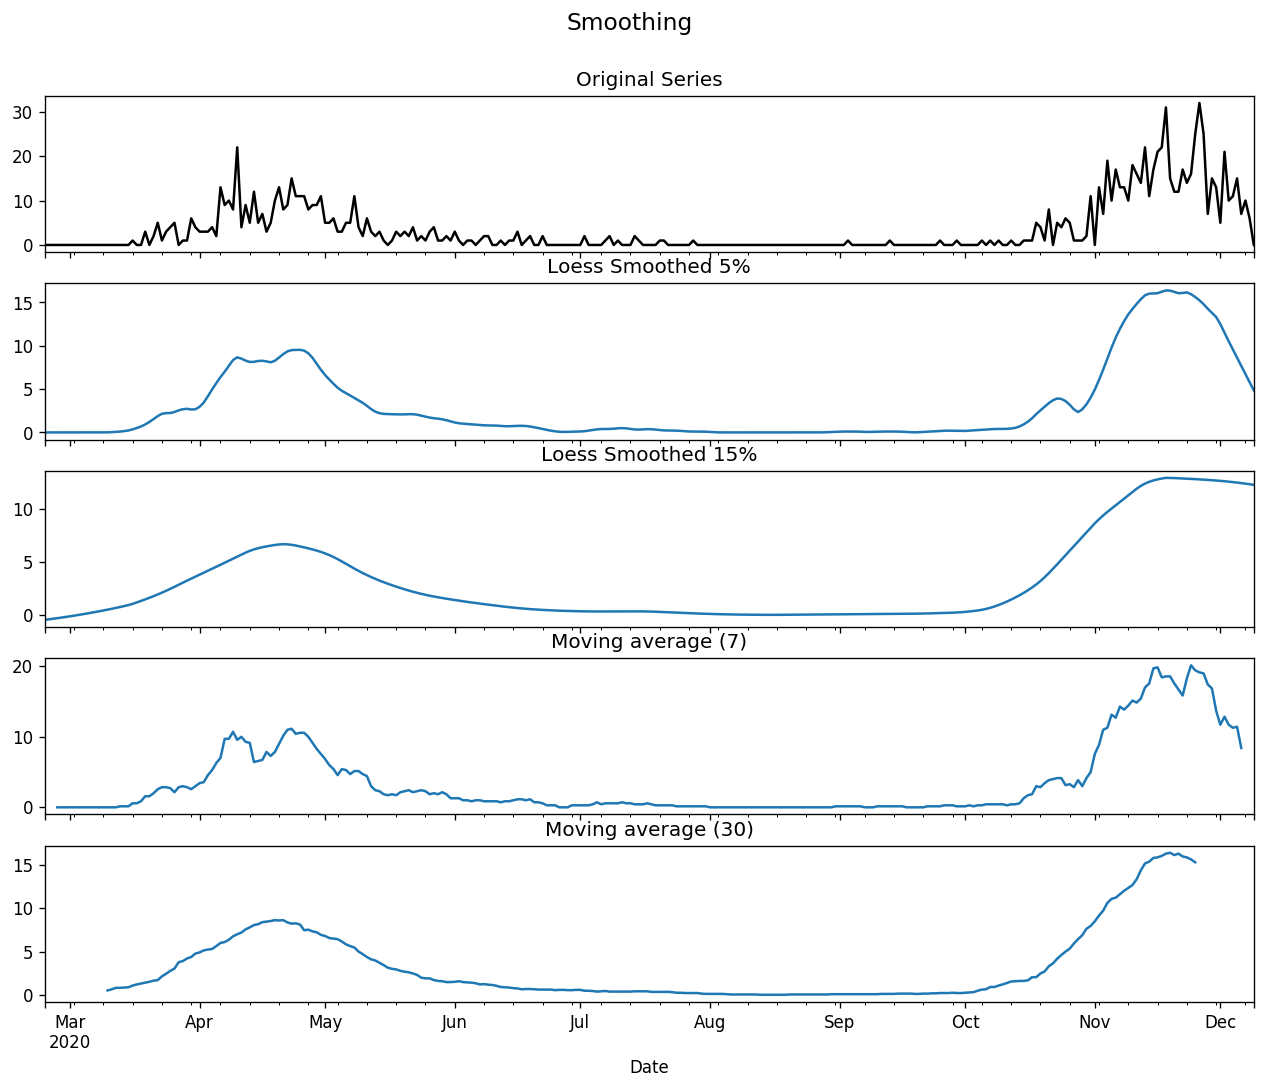

In [40]:
# Smoothing
plot_smoothing(tmp_df, compart)

In [41]:
"""
Granger causality tests:

Infected - Month
Infected - Deaths
"""

tmp_df = covidpro_df[covidpro_df.Province == province]

tmp_df['month'] = tmp_df[date].dt.month
gc_res = grangercausalitytests(tmp_df[[compart, 'month']], maxlag=3)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.8913  , p=0.0901  , df_denom=286, df_num=1
ssr based chi2 test:   chi2=2.9216  , p=0.0874  , df=1
likelihood ratio test: chi2=2.9069  , p=0.0882  , df=1
parameter F test:         F=2.8913  , p=0.0901  , df_denom=286, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.6630  , p=0.1914  , df_denom=283, df_num=2
ssr based chi2 test:   chi2=3.3847  , p=0.1841  , df=2
likelihood ratio test: chi2=3.3649  , p=0.1859  , df=2
parameter F test:         F=1.6630  , p=0.1914  , df_denom=283, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.0205  , p=0.3840  , df_denom=280, df_num=3
ssr based chi2 test:   chi2=3.1379  , p=0.3708  , df=3
likelihood ratio test: chi2=3.1209  , p=0.3734  , df=3
parameter F test:         F=1.0205  , p=0.3840  , df_denom=280, df_num=3


In [42]:
gc_res = grangercausalitytests(tmp_df[[compart, 'Deaths']], maxlag=3)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0000  , p=1.0000  , df_denom=287, df_num=1
ssr based chi2 test:   chi2=0.0000  , p=1.0000  , df=1
likelihood ratio test: chi2=-0.0000 , p=1.0000  , df=1
parameter F test:         F=485.5733, p=0.0000  , df_denom=287, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.0000  , p=1.0000  , df_denom=285, df_num=2
ssr based chi2 test:   chi2=0.0000  , p=1.0000  , df=2
likelihood ratio test: chi2=-0.0000 , p=1.0000  , df=2
parameter F test:         F=339.8168, p=0.0000  , df_denom=285, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=-0.0000 , p=1.0000  , df_denom=283, df_num=3
ssr based chi2 test:   chi2=-0.0000 , p=1.0000  , df=3
likelihood ratio test: chi2=-0.0000 , p=1.0000  , df=3
parameter F test:         F=232.1738, p=0.0000  , df_denom=283, df_num=3


## Exploration TS: infected Piemonte

In [43]:
province = "Piemonte"
compart = "nuovi_positivi"
date = 'data'

In [44]:
tmp_df = dpc_regioni_df[dpc_regioni_df.denominazione_regione == province]

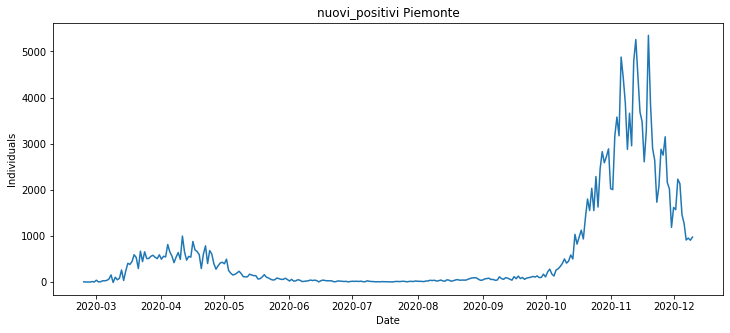

In [45]:
visualize_ts(tmp_df, date, compart, province)

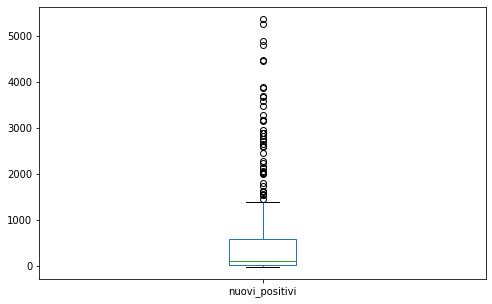

In [46]:
show_boxplot(tmp_df, compart)

In [47]:
tmp_df = tmp_df.set_index(date)

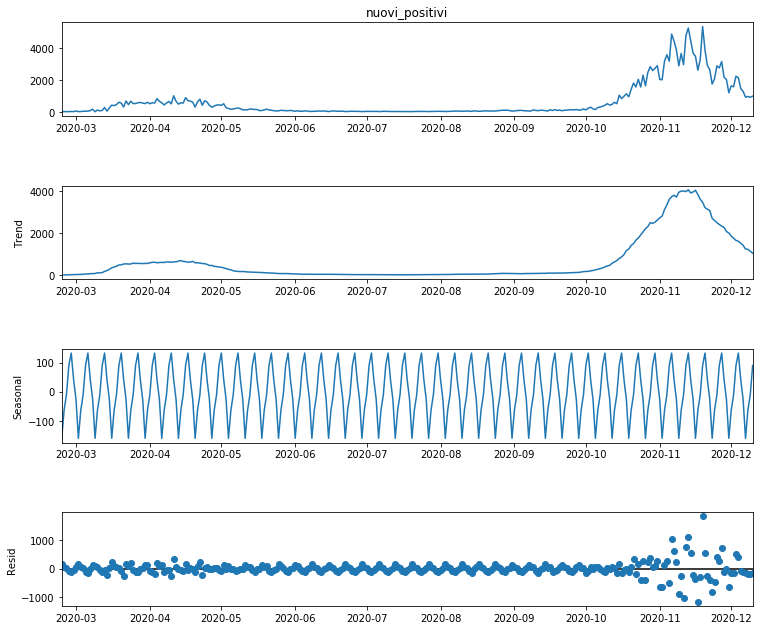

In [48]:
# Additive Decomposition
plot_decomposition(tmp_df, compart)

In [49]:
# Test for stationarity
adf_test(tmp_df[compart].values)

ADF Statistic: -3.3560158064650696
p-value: 0.012552855296211371
Critial Values:
   1%, -3.4540935579190495
Critial Values:
   5%, -2.8719934111688965
Critial Values:
   10%, -2.5723401594120388


In [50]:
# Test for trend stationarity
kpss_test(tmp_df[compart].values)


KPSS Statistic: 0.703087
p-value: 0.013265
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


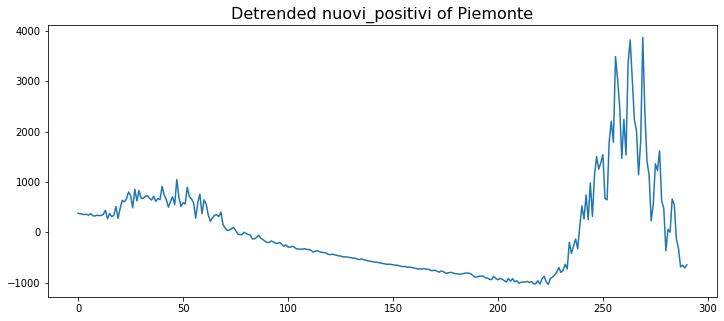

In [51]:
# Detrend by subtracting best leastsq fit
plot_detrended_deseason(
    signal.detrend(tmp_df[compart].values), 
    province,
    compart,
    "Detrended")

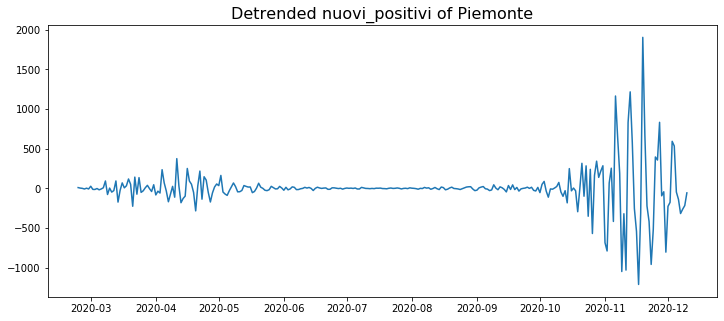

In [52]:
# Detrend by subtracting trend comp
plot_detrended_deseason(
    remove_trend(tmp_df, compart), 
    province,
    compart,
    "Detrended")

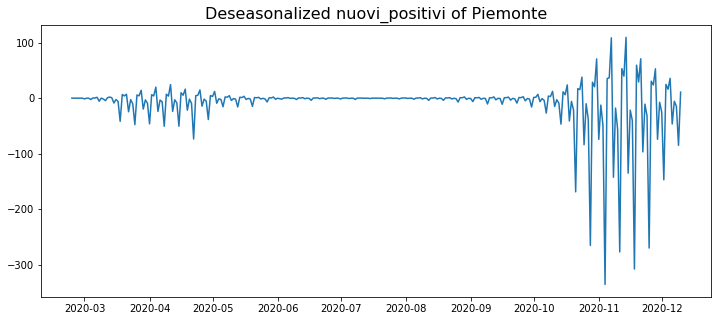

In [53]:
# Deseasonalize by subtracting trend
plot_detrended_deseason(
    deseason_trend(tmp_df, compart), 
    province,
    compart,
    "Deseasonalized")

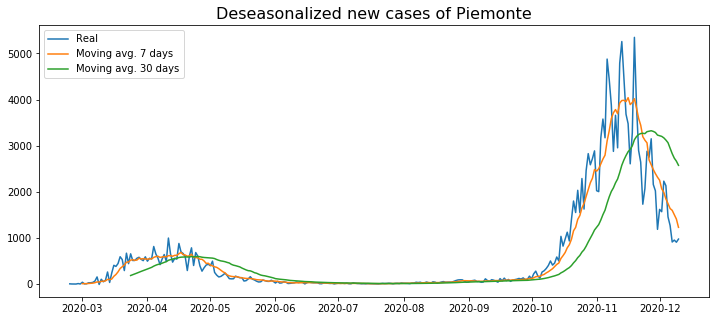

In [54]:
# Deseasonalize by taking mov. avg. with length = seasonal window
plot_deseason_ma(tmp_df, compart, province)

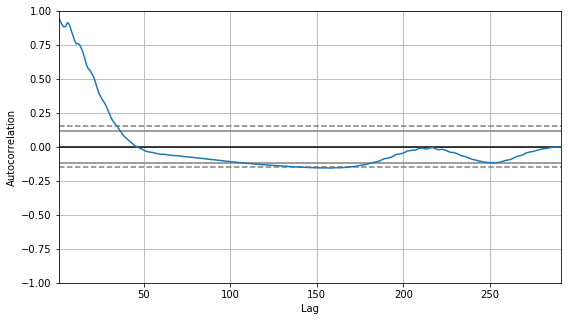

In [55]:
# Seasonality test
plot_autocorr(tmp_df, compart)

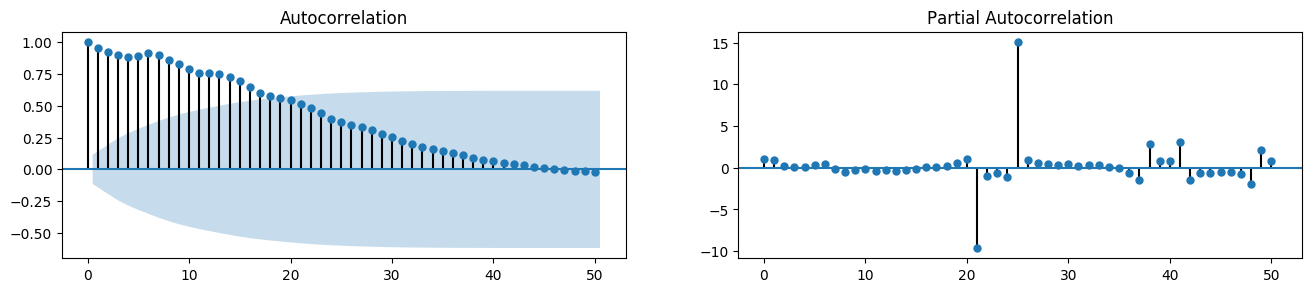

In [56]:
# Autocorrelation and partial autocorrelation
plot_acf_pacf(tmp_df, compart)

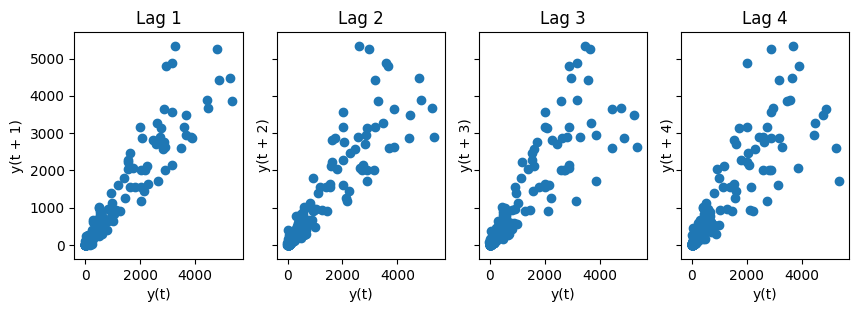

In [57]:
"""
Lag plots:
If points get wide and scattered with increasing lag, 
this means lesser correlation
"""

plot_lag_plots(tmp_df, compart)

In [58]:
# Estimate forecastability
print("SampEn:", SampEn(tmp_df[compart].values, m=2, r=0.2*np.std(tmp_df[compart].values)))
print("ApproxEn:", ApEn(tmp_df[compart].values, m=2, r=0.2*np.std(tmp_df[compart].values))) 

SampEn: 0.05778282138264353
ApproxEn: 0.22056687391795093


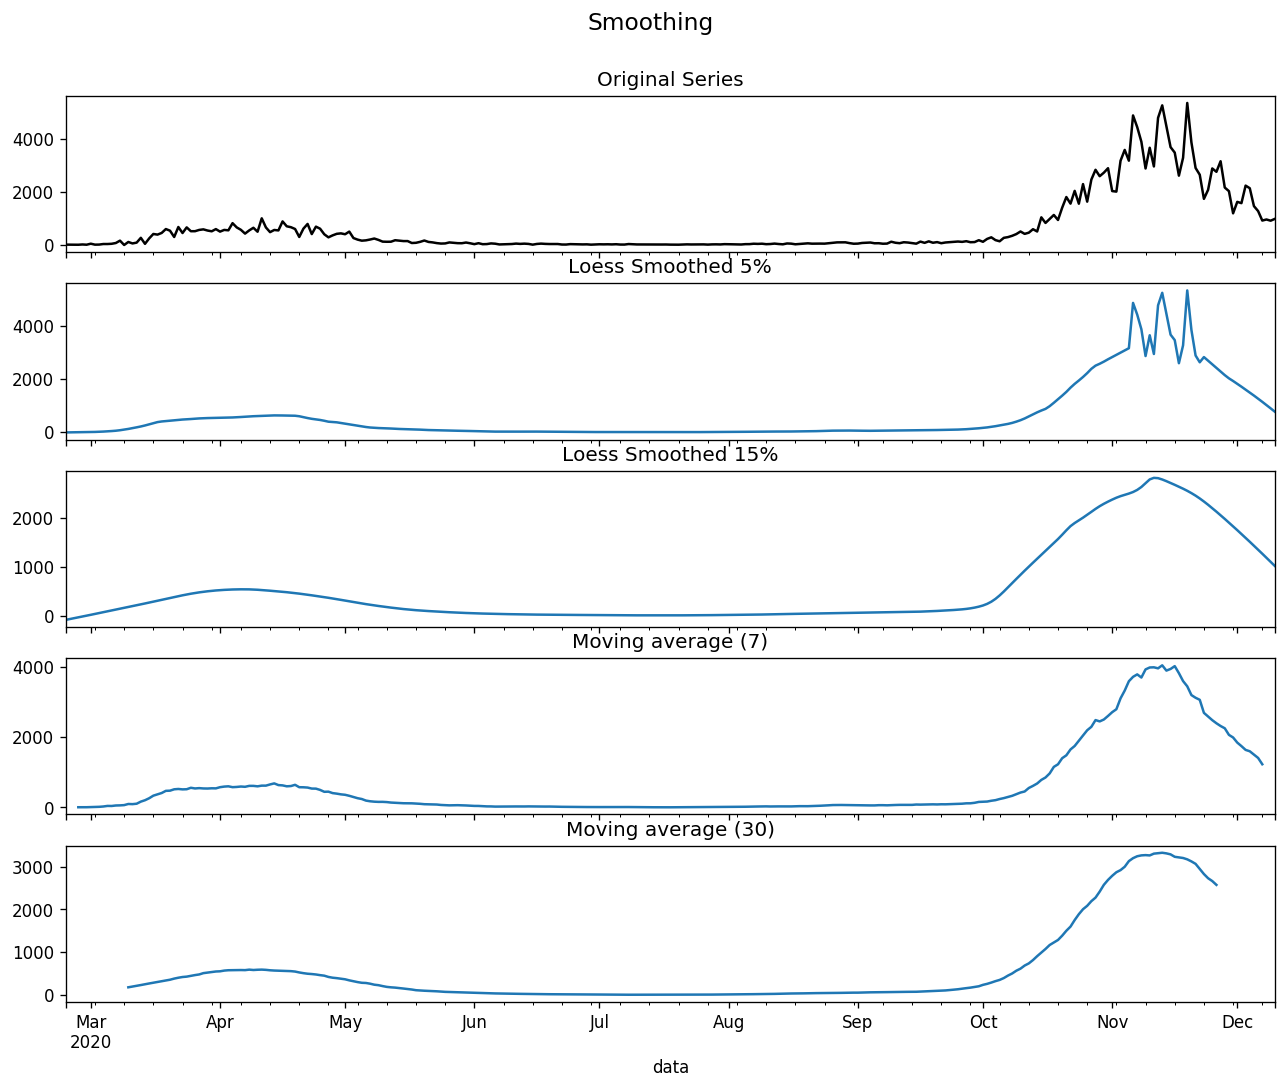

In [59]:
# Smoothing
plot_smoothing(tmp_df, compart)

In [60]:
"""
Granger causality tests:

Deaths - Month
Deaths - Infected
"""


tmp_df = dpc_regioni_df[dpc_regioni_df.denominazione_regione == province]

tmp_df['month'] = tmp_df[date].dt.month
gc_res = grangercausalitytests(tmp_df[[compart, 'month']], maxlag=3)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.8526  , p=0.0923  , df_denom=287, df_num=1
ssr based chi2 test:   chi2=2.8824  , p=0.0896  , df=1
likelihood ratio test: chi2=2.8682  , p=0.0903  , df=1
parameter F test:         F=2.8526  , p=0.0923  , df_denom=287, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.0530  , p=0.3502  , df_denom=284, df_num=2
ssr based chi2 test:   chi2=2.1431  , p=0.3425  , df=2
likelihood ratio test: chi2=2.1352  , p=0.3438  , df=2
parameter F test:         F=1.0530  , p=0.3502  , df_denom=284, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.2254  , p=0.3007  , df_denom=281, df_num=3
ssr based chi2 test:   chi2=3.7677  , p=0.2877  , df=3
likelihood ratio test: chi2=3.7433  , p=0.2906  , df=3
parameter F test:         F=1.2254  , p=0.3007  , df_denom=281, df_num=3


In [61]:
gc_res = grangercausalitytests(tmp_df[[compart, 'deceduti']], maxlag=3)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0547  , p=0.8152  , df_denom=287, df_num=1
ssr based chi2 test:   chi2=0.0553  , p=0.8141  , df=1
likelihood ratio test: chi2=0.0553  , p=0.8141  , df=1
parameter F test:         F=0.0547  , p=0.8152  , df_denom=287, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.0057  , p=0.9943  , df_denom=284, df_num=2
ssr based chi2 test:   chi2=0.0117  , p=0.9942  , df=2
likelihood ratio test: chi2=0.0117  , p=0.9942  , df=2
parameter F test:         F=0.0057  , p=0.9943  , df_denom=284, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.0785  , p=0.9716  , df_denom=281, df_num=3
ssr based chi2 test:   chi2=0.2413  , p=0.9707  , df=3
likelihood ratio test: chi2=0.2412  , p=0.9707  , df=3
parameter F test:         F=0.0785  , p=0.9716  , df_denom=281, df_num=3


## Anomalies plot

In [62]:
province = "Firenze"
compart = "New_cases"
date = 'Date'

tmp_df = covidpro_df[covidpro_df.Province == province]
tmp_df = tmp_df.set_index(date)

In [59]:
def mape(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [64]:
def adv_ma_plot(df, compart, window, plot_intervals=False, scale=1.96, plot_anomalies=False, show_anomalies_label=False, legend_position='upper left'):
    rolling_mean = df[[compart]].rolling(window=window).mean()

    plt.figure(figsize=(15,5))
    #plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    if plot_intervals:
        mae = mean_absolute_error(df[[compart]][window:], rolling_mean[window:])
        deviation = np.std(df[[compart]][window:] - rolling_mean[window:])
        lower_bound = rolling_mean - (mae + scale * deviation)
        upper_bound = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bound, "r--", label="Upper Bound / Lower Bound")
        plt.plot(lower_bound, "r--")
        
        if plot_anomalies:
            
            anomalies = pd.DataFrame(index=df[[compart]].index, columns=df[[compart]].columns)
            anomalies[df[[compart]]<lower_bound] = df[[compart]][df[[compart]]<lower_bound]
            anomalies[df[[compart]]>upper_bound] = df[[compart]][df[[compart]]>upper_bound]
            plt.plot(anomalies, "ro", markersize=10)

            if show_anomalies_label:
                ymin, ymax = plt.ylim()
                plt.vlines(anomalies.dropna().index, ymin=ymin, ymax=ymax, linestyles='dashed', colors='grey')
                for x in anomalies.dropna().index:
                    plt.text(x, ymin + 20, x.strftime('%m-%d'), rotation=90, verticalalignment='center')
        
    plt.plot(df[[compart]][window:], label="Actual values")
    plt.legend(loc=legend_position)
    plt.show()

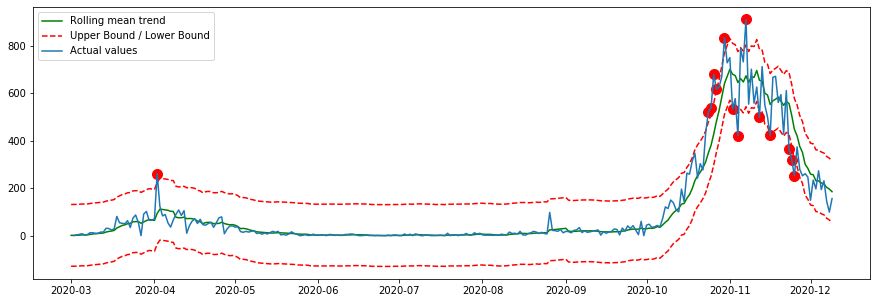

In [65]:
adv_ma_plot(tmp_df, compart, 7, plot_intervals=True, plot_anomalies=True)

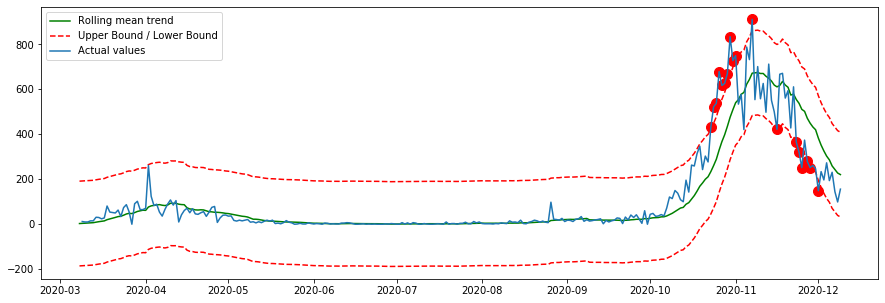

In [66]:
adv_ma_plot(tmp_df, compart, 14, plot_intervals=True, plot_anomalies=True)

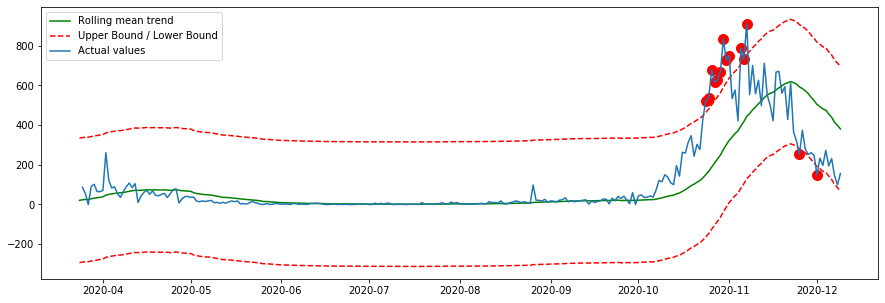

In [67]:
adv_ma_plot(tmp_df, compart, 30, plot_intervals=True, plot_anomalies=True)

In [68]:
province = "Firenze"
compart = "New_cases"
date = 'Date'

tmp_df = covidpro_df[covidpro_df.Province == province].query('20200701 > Date')
tmp_df = tmp_df.set_index(date)

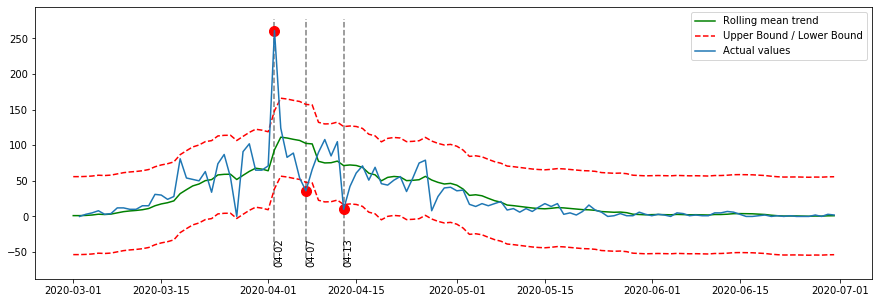

In [69]:
adv_ma_plot(tmp_df, compart, 7, plot_intervals=True, plot_anomalies=True, show_anomalies_label=True, legend_position='upper right')

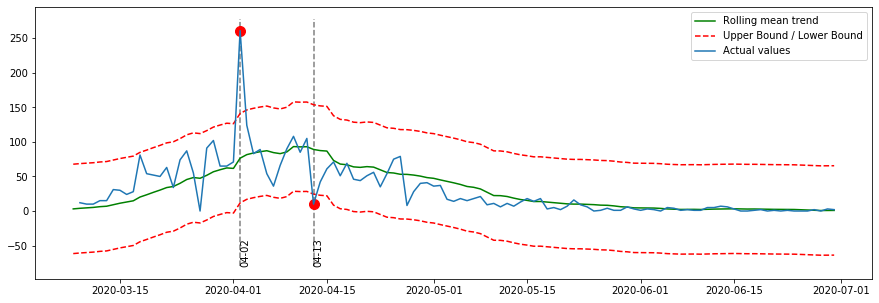

In [70]:
adv_ma_plot(tmp_df, compart, 14, plot_intervals=True, plot_anomalies=True, show_anomalies_label=True, legend_position='upper right')

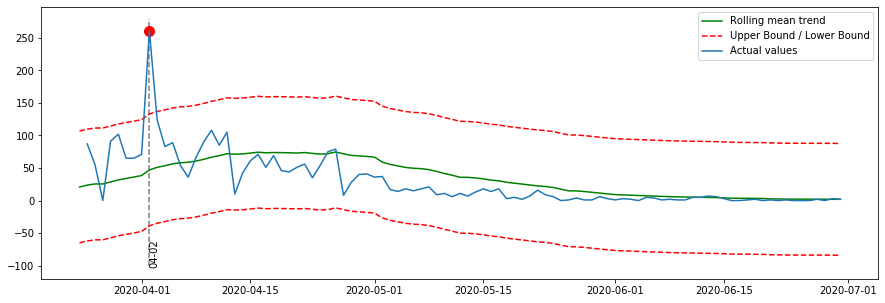

In [71]:
adv_ma_plot(tmp_df, compart, 30, plot_intervals=True, plot_anomalies=True, show_anomalies_label=True, legend_position='upper right')

In [72]:
province = "Firenze"
compart = "New_cases"
date = 'Date'

tmp_df = covidpro_df[covidpro_df.Province == province].query('20201208 > Date > 20200701')
tmp_df = tmp_df.set_index(date)

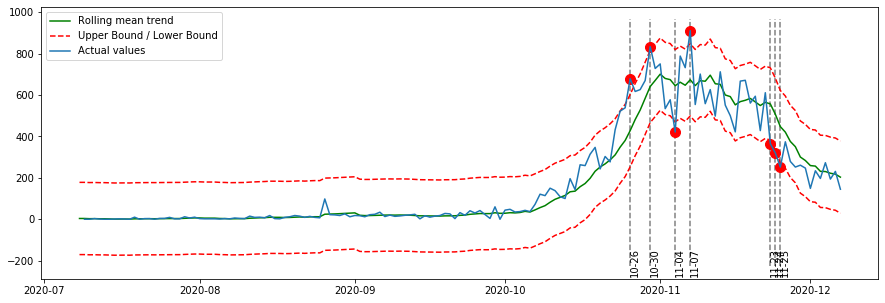

In [73]:
adv_ma_plot(tmp_df, compart, 7, plot_intervals=True, plot_anomalies=True, show_anomalies_label=True, legend_position='upper left')

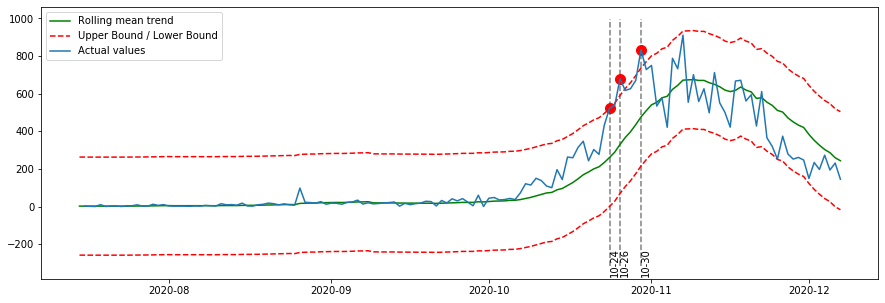

In [74]:
adv_ma_plot(tmp_df, compart, 14, plot_intervals=True, plot_anomalies=True, show_anomalies_label=True, legend_position='upper left')

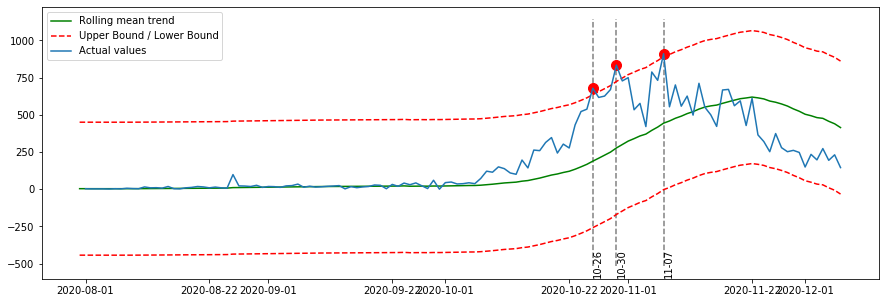

In [75]:
adv_ma_plot(tmp_df, compart, 30, plot_intervals=True, plot_anomalies=True, show_anomalies_label=True, legend_position='upper left')

## Prediction

### Exponential Smoothing and Holt-Winters

In [6]:
province = "Firenze"
compart = "New_cases"
date = 'Date'

tmp_df = covidpro_df[covidpro_df.Province == province].query('20200701 > Date')
tmp_df.loc[(tmp_df.Date == pd.Timestamp(2020, 4, 2)), "New_cases"] = np.nan
tmp_df["New_cases"].interpolate(inplace=True)
tmp_df.loc[(tmp_df.Date == pd.Timestamp(2020, 4, 2)), "New_cases"] = np.round(tmp_df.loc[(tmp_df.Date == pd.Timestamp(2020, 4, 2)), "New_cases"])
#tmp_df[compart] = tmp_df[compart].apply(lambda x: 0 if x is np.nan or x < 0 else x)
tmp_df.astype({"New_cases": "int32"})
tmp_df = tmp_df.set_index(date)

In [7]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing, Holt

train = tmp_df[[compart]].query('20200615 > Date')
test = tmp_df[[compart]].query('20200615 <= Date')

model = ExponentialSmoothing(train[compart].values)
model_fit = model.fit()

yhat = model_fit.predict(start=0,end=len(test)-1)

In [27]:
print("MAE:", mean_absolute_error(test, yhat))
print("MSE:", mean_squared_error(test, yhat))
print("RMSE:", mean_squared_error(test, yhat, squared=False))

MAE: 2.0730830739525388
MSE: 6.975609362546363
RMSE: 2.6411378916191337


In [28]:
print("AIC:", model_fit.aic)
print("AICC:", model_fit.aicc)
print("BIC:", model_fit.bic)
print("k:", model_fit.k)
print("SSE:", model_fit.sse)
print("\n",model_fit.mle_retvals)

AIC: 656.2053176338434
AICC: 656.5791494095444
BIC: 661.6423153764335
k: 2
SSE: 37864.17282293216

      fun: 37864.17282293216
     jac: array([0.02880859, 0.00048828])
 message: 'Optimization terminated successfully.'
    nfev: 25
     nit: 5
    njev: 5
  status: 0
 success: True
       x: array([0.31869206, 1.05100326])


In [29]:
model_fit.params_formatted

name     param  optimized
smoothing_level  alpha  0.318692       True
initial_level      l.0  1.051003       True

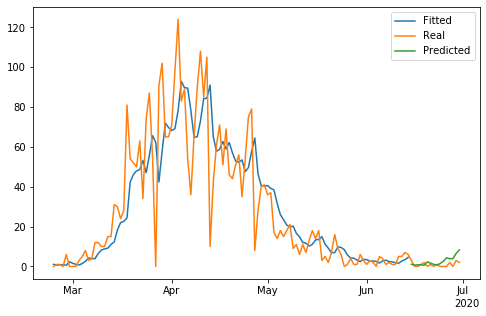

In [30]:
#plt.figure(figsize=(8,5))
#plt.plot(train.index, model_fit.fittedvalues, label='Fitted')
#plt.plot(tmp_df.index, tmp_df[compart].values, label='Real')
#plt.plot(test.index, yhat, label='Predicted')
#plt.legend()
#plt.show()


fig, ax = plt.subplots(figsize=(8,5))
locator = mdates.AutoDateLocator(minticks=3)
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
ax.plot(train.index, model_fit.fittedvalues, label='Fitted')
ax.plot(tmp_df.index, tmp_df[compart].values, label='Real')
ax.plot(test.index, yhat, label='Predicted')
plt.legend()
plt.show()

In [31]:
model = Holt(train[compart].values)

# It works with Powell or leastsq, but not with
# the default L-BFGS-B
model_fit = model.fit(method='Powell')

yhat = model_fit.predict(start=0,end=len(test)-1)

print("AIC:", model_fit.aic)
print("AICC:", model_fit.aicc)
print("BIC:", model_fit.bic)
print("k:", model_fit.k)
print("SSE:", model_fit.sse)
print("\n",model_fit.mle_retvals)

AIC: 657.2857815834844
AICC: 658.0857815834844
BIC: 668.1597770686648
k: 4
SSE: 36889.909956354415

    direc: array([[ 0.        ,  0.        ,  0.        ,  1.        ],
       [-0.01065353,  0.0920848 ,  0.5055263 , -0.08930595],
       [ 0.        ,  0.        ,  1.        ,  0.        ],
       [-0.00874355,  0.17655601,  0.04365726, -0.28981009]])
     fun: 36889.909956354415
 message: 'Optimization terminated successfully.'
    nfev: 238
     nit: 5
  status: 0
 success: True
       x: array([ 0.15838621,  0.22455304, -4.26962293, -0.18676495])


In [32]:
print("MAE:", mean_absolute_error(test, yhat))
print("MSE:", mean_squared_error(test, yhat))
print("RMSE:", mean_squared_error(test, yhat, squared=False))

MAE: 3.468290108898218
MSE: 16.83948786329467
RMSE: 4.10359450522279


In [33]:
model_fit.params_formatted

name     param  optimized
smoothing_level  alpha  0.158386       True
smoothing_trend   beta  0.224553       True
initial_level      l.0 -4.269623       True
initial_trend      b.0 -0.186765       True

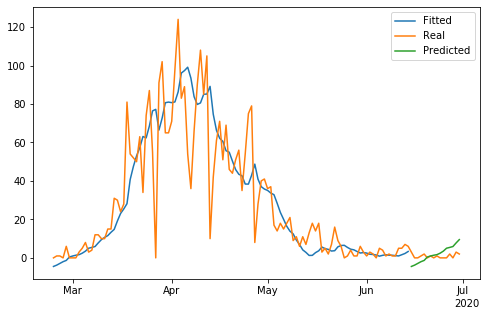

In [34]:
#plt.figure(figsize=(8,5))
#plt.plot(train.index, model_fit.fittedvalues, label='Fitted')
#plt.plot(tmp_df.index, tmp_df[compart].values, label='Real')
#plt.plot(test.index, yhat, label='Predicted')
#plt.legend()
#plt.show()

fig, ax = plt.subplots(figsize=(8,5))
locator = mdates.AutoDateLocator(minticks=3)
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
ax.plot(train.index, model_fit.fittedvalues, label='Fitted')
ax.plot(tmp_df.index, tmp_df[compart].values, label='Real')
ax.plot(test.index, yhat, label='Predicted')
plt.legend()
plt.show()

In [35]:
model_es = ExponentialSmoothing(train[compart].values)
model_fit_es = model_es.fit()

yhat_es = model_fit_es.predict(start=0,end=len(test)-1)

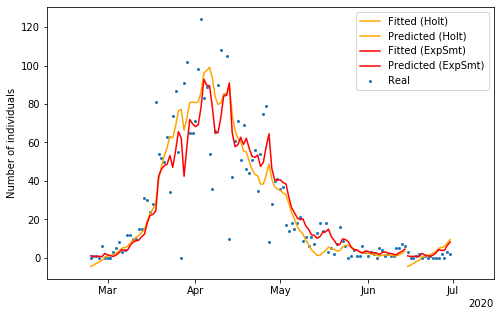

In [36]:
#plt.figure(figsize=(8,5))
#plt.plot(train.index, model_fit.fittedvalues, label='Fitted (Holt)')
#plt.plot(test.index, yhat, label='Predicted (Holt)')
#plt.plot(train.index, model_fit_es.fittedvalues, label='Fitted (ExpSmt)')
#plt.plot(test.index, yhat_es, label='Predicted (ExpSmt)')
#plt.plot(tmp_df.index, tmp_df[compart].values, label='Real')
#plt.legend()
#plt.show()

fig, ax = plt.subplots(figsize=(8,5))
locator = mdates.AutoDateLocator(minticks=3)
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
ax.scatter(tmp_df.index, tmp_df[compart].values, label='Real', s=4)
ax.plot(train.index, model_fit.fittedvalues, label='Fitted (Holt)', color="orange")
ax.plot(test.index, yhat, label='Predicted (Holt)', color="orange")
ax.plot(train.index, model_fit_es.fittedvalues, label='Fitted (ExpSmt)', color="red")
ax.plot(test.index, yhat_es, label='Predicted (ExpSmt)', color="red")
plt.legend()
plt.ylabel("Number of individuals")
plt.show()

### Deasonalize, detrend and make stationary
New_cases

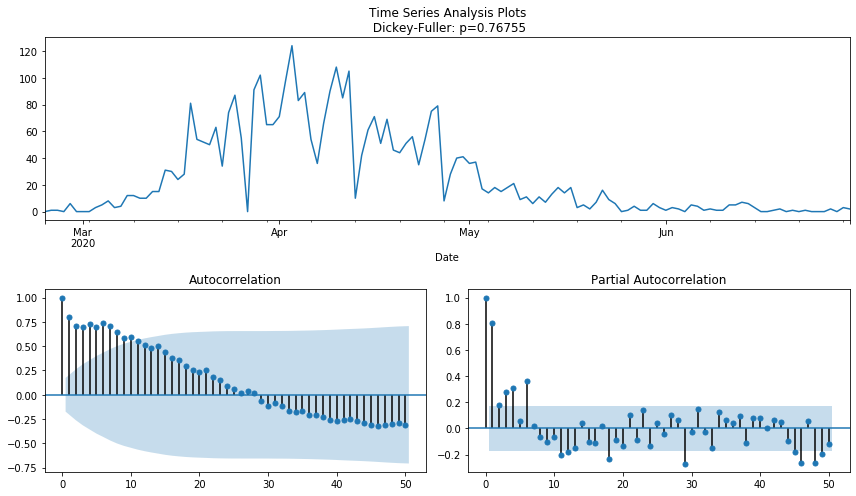

In [40]:
tsplot(tmp_df[compart], lags=50)

In [41]:
adf_test(tmp_df[compart].values)
kpss_test(tmp_df[compart].values)

ADF Statistic: -0.9600587998949696
p-value: 0.7675518785663014
Critical Values:
   1%, -3.4851223522012855
Critical Values:
   5%, -2.88553750045158
Critical Values:
   10%, -2.5795685622144586

KPSS Statistic: 0.392363
p-value: 0.080447
Critical Values:
   10%, 0.347
Critical Values:
   5%, 0.463
Critical Values:
   2.5%, 0.574
Critical Values:
   1%, 0.739


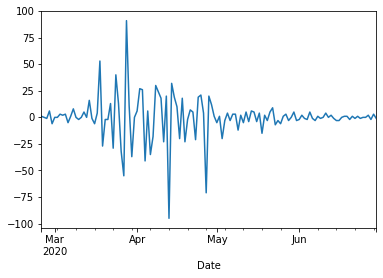

In [42]:
res = tmp_df[compart] - tmp_df[compart].shift(1)
res.dropna().plot()
plt.show()

In [43]:
adf_test(res.dropna().values)
kpss_test(res.dropna().values)

ADF Statistic: -9.626634626858927
p-value: 1.6539339758754491e-16
Critical Values:
   1%, -3.4851223522012855
Critical Values:
   5%, -2.88553750045158
Critical Values:
   10%, -2.5795685622144586

KPSS Statistic: 0.211116
p-value: 0.100000
Critical Values:
   10%, 0.347
Critical Values:
   5%, 0.463
Critical Values:
   2.5%, 0.574
Critical Values:
   1%, 0.739
/home/nick/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1876: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.




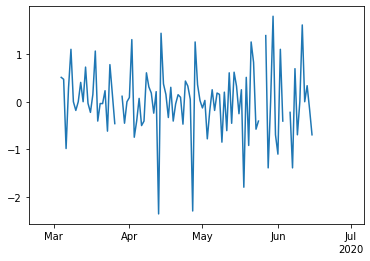

In [18]:
res = np.log(tmp_df[compart]) - np.log(tmp_df[compart]).shift(1)

fig, ax = plt.subplots()
locator = mdates.AutoDateLocator(minticks=3)
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
ax.plot(res.dropna())
#res.dropna().plot()
plt.show()

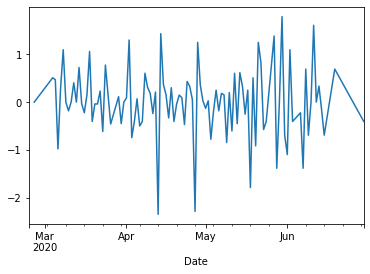

In [19]:
res_fix = res.replace([np.inf, -np.inf], np.nan).interpolate(method='time')
res_fix.plot()
plt.show()

In [20]:
# Shows that is stationary. Remember that KPSS null-hypo is opposite
# to ADF. We have to remove the trend and seasonality.
adf_test(res_fix.dropna().values)
kpss_test(res_fix.dropna().values)

ADF Statistic: -10.374148574924691
p-value: 2.224126550856314e-18
Critial Values:
   1%, -3.484219653271961
Critial Values:
   5%, -2.885145235641637
Critial Values:
   10%, -2.579359138917794

KPSS Statistic: 0.180195
p-value: 0.100000
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739
/home/nick/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1876: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(warn_msg.format(direction="greater"), InterpolationWarning)


In [21]:
res_fix.dropna(inplace=True)

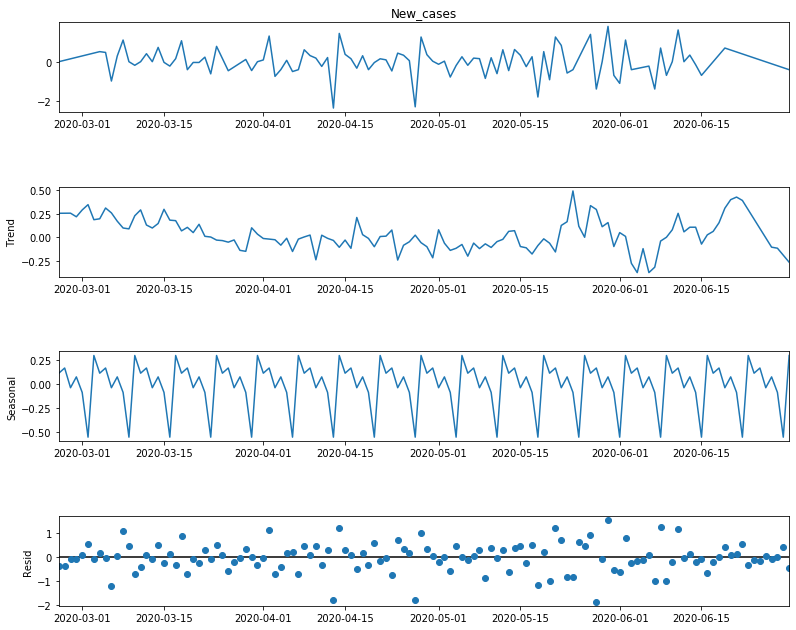

In [22]:
decomposed = seasonal_decompose(res_fix, model='additive', extrapolate_trend='freq')
plot_decomposition(result=decomposed)

In [23]:
detrended = res_fix - decomposed.trend
deseasonalized = detrended / decomposed.seasonal

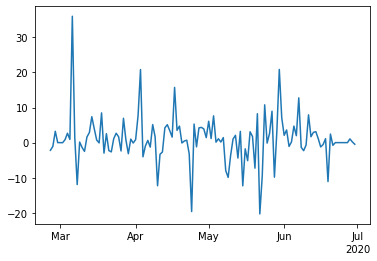

In [24]:
fig, ax = plt.subplots()
locator = mdates.AutoDateLocator(minticks=3)
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
ax.plot(deseasonalized)
plt.show()

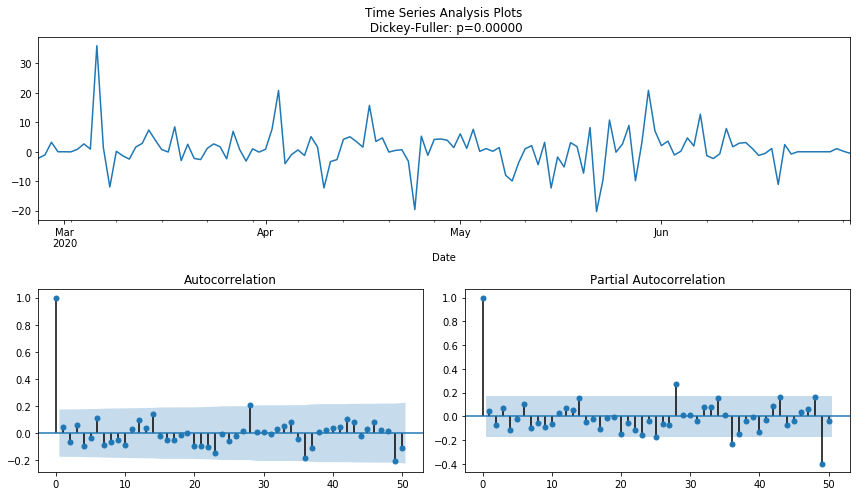

In [25]:
tsplot(deseasonalized, lags=50)

In [26]:
adf_test(deseasonalized.values)
kpss_test(deseasonalized.values)

ADF Statistic: -10.589650606104959
p-value: 6.578190158075751e-19
Critial Values:
   1%, -3.4837793736959997
Critial Values:
   5%, -2.88495387648
Critial Values:
   10%, -2.579256976

KPSS Statistic: 0.138756
p-value: 0.100000
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739
/home/nick/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1876: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(warn_msg.format(direction="greater"), InterpolationWarning)


### AR

In [7]:
model = AutoReg(train, lags=1)
model_fit = model.fit()

# make prediction
yhat = model_fit.predict(test.index[0], test.index[-1])

/home/nick/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


In [8]:
mean_absolute_error(test, yhat), mean_squared_error(test, yhat)

(27.37116829411773, 776.8755739975904)

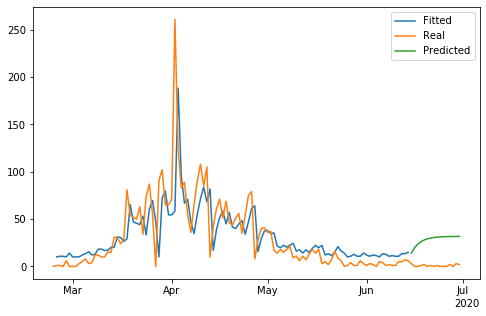

In [9]:
fig, ax = plt.subplots(figsize=(8,5))
locator = mdates.AutoDateLocator(minticks=3)
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
ax.plot(model_fit.fittedvalues.index, model_fit.fittedvalues.values, label='Fitted')
ax.plot(tmp_df[compart].index, tmp_df[compart].values, label='Real')
ax.plot(test.index, yhat, label='Predicted')
plt.legend()
plt.show()

[]

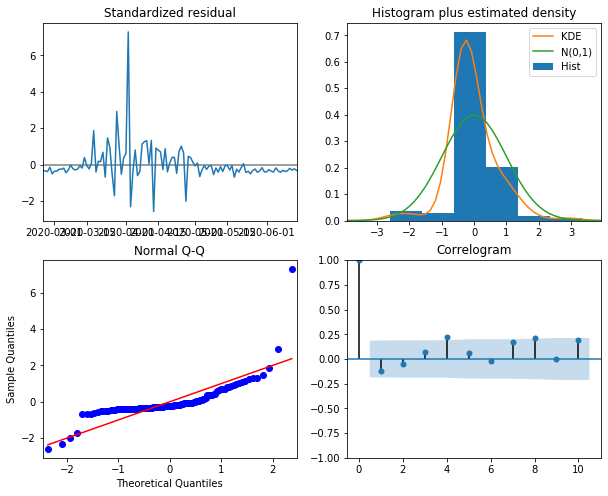

In [10]:
model_fit.plot_diagnostics(figsize=(10,8))
plt.plot()

In [11]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:              New_cases   No. Observations:                  112
Model:                     AutoReg(1)   Log Likelihood                -526.365
Method:               Conditional MLE   S.D. of innovations             27.746
Date:                Mon, 28 Dec 2020   AIC                              6.700
Time:                        18:36:34   BIC                              6.773
Sample:                    02-25-2020   HQIC                             6.730
                         - 06-14-2020                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
intercept       10.0673      3.423      2.941      0.003       3.359      16.776
New_cases.L1     0.6832      0.069      9.876      0.000       0.548       0.819
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.4638           +0.0000j            1.4638            0.0000
-----------------------------------------------------------------------------
"""

In [12]:
model_fit.diagnostic_summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
       Test of No Serial Correlation       
===========================================
       Lag  Ljung-Box LB P-value         DF
-------------------------------------------
         1      2.133      0.144          1
         2      2.634      0.268          2
         3      8.285      0.040          3
         4      8.789      0.067          4
         5      8.842      0.116          5
         6     12.368      0.054          6
         7     17.811      0.013          7
         8     17.813      0.023          8
         9     22.607      0.007          9
        10     22.991      0.011         10
        11     23.324      0.016         11


             Test of Normality              
============================================
Jarque-Bera    P-value   Skewness   Kurtosis
--------------------------------------------
   2980.853      0.000      3.524     27.389


    Test of Conditional Homoskedasticity   
===========================================
       Lag    ARCH-LM    P-value         DF
-------------------------------------------
         1      0.885      0.347          1
         2      0.956      0.620          2
         3      0.945      0.815          3
         4      0.936      0.919          4
         5      2.797      0.731          5
         6      2.938      0.817          6
         7      2.902      0.894          7
         8      2.897      0.941          8
         9      2.869      0.969          9
        10      2.843      0.985         10
        11      3.553      0.981         11
        12      3.583      0.990         12
-------------------------------------------
"""

In [13]:
model_fit.conf_int()

0          1
intercept     3.358958  16.775667
New_cases.L1  0.547580   0.818741

### MA

In [14]:
model = ARIMA(train, order=(0, 0, 1))
model_fit = model.fit()

# make prediction
yhat = model_fit.predict(test.index[0], test.index[-1])

/home/nick/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/nick/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/nick/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


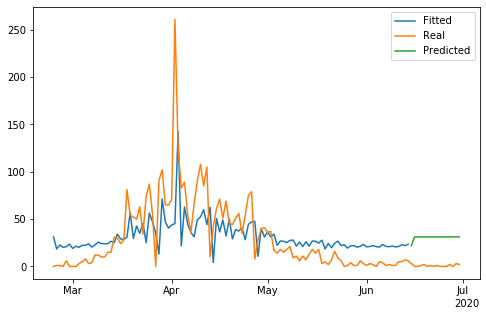

In [16]:
fig, ax = plt.subplots(figsize=(8,5))
locator = mdates.AutoDateLocator(minticks=3)
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
ax.plot(model_fit.fittedvalues.index, model_fit.fittedvalues.values, label='Fitted')
ax.plot(tmp_df[compart].index, tmp_df[compart].values, label='Real')
ax.plot(test.index, yhat, label='Predicted')
plt.legend()
plt.show()

[]

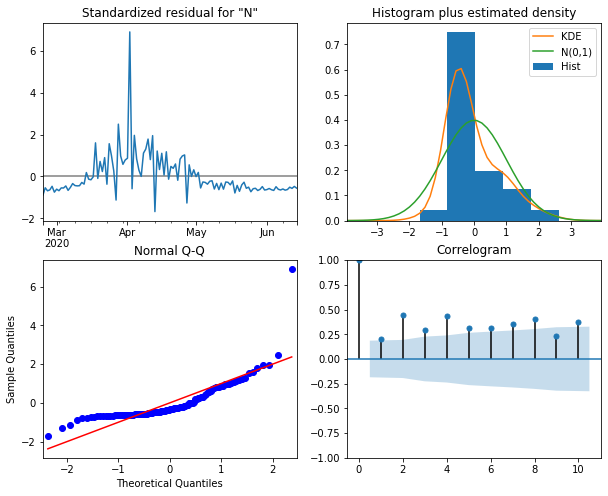

In [17]:
model_fit.plot_diagnostics(figsize=(10,8))
plt.plot()

In [18]:
mean_absolute_error(test, yhat), mean_squared_error(test, yhat)

(29.701556472778492, 890.4492769527631)

In [19]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              New_cases   No. Observations:                  112
Model:                 ARIMA(0, 0, 1)   Log Likelihood                -544.524
Date:                Mon, 28 Dec 2020   AIC                           1095.049
Time:                        18:49:13   BIC                           1103.204
Sample:                    02-24-2020   HQIC                          1098.358
                         - 06-14-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         31.2024      6.566      4.752      0.000      18.334      44.071
ma.L1          0.5155      0.079      6.502      0.000       0.360       0.671
sigma2       975.6128     61.894     15.763      0.000     854.303    1096.922
===================================================================================
Ljung-Box (L1) (Q):                   4.87   Jarque-Bera (JB):              1793.73
Prob(Q):                              0.03   Prob(JB):                         0.00
Heteroskedasticity (H):               0.50   Skew:                             3.31
Prob(H) (two-sided):                  0.04   Kurtosis:                        21.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [20]:
model_fit.conf_int()

0            1
const    18.333761    44.070953
ma.L1     0.360067     0.670836
sigma2  854.303397  1096.922155

### ARMA

In [21]:
#ARMA
model = ARIMA(train, order=(2, 0, 1))
model_fit = model.fit()

# make prediction
yhat = model_fit.predict(test.index[0], test.index[-1])

/home/nick/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/nick/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/nick/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


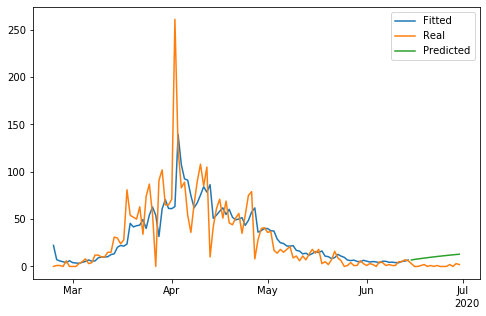

In [22]:
fig, ax = plt.subplots(figsize=(8,5))
locator = mdates.AutoDateLocator(minticks=3)
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
ax.plot(model_fit.fittedvalues.index, model_fit.fittedvalues.values, label='Fitted')
ax.plot(tmp_df[compart].index, tmp_df[compart].values, label='Real')
ax.plot(test.index, yhat, label='Predicted')
plt.legend()
plt.show()

[]

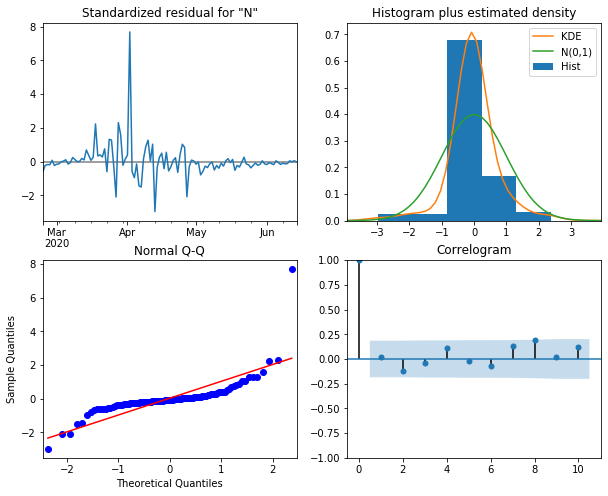

In [23]:
model_fit.plot_diagnostics(figsize=(10,8))
plt.plot()

In [24]:
mean_absolute_error(test, yhat), mean_squared_error(test, yhat)

(9.202485412359536, 89.02252350369098)

In [25]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              New_cases   No. Observations:                  112
Model:                 ARIMA(2, 0, 1)   Log Likelihood                -523.022
Date:                Mon, 28 Dec 2020   AIC                           1056.044
Time:                        18:49:30   BIC                           1069.636
Sample:                    02-24-2020   HQIC                          1061.559
                         - 06-14-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         22.2281     48.262      0.461      0.645     -72.364     116.821
ar.L1          1.1589      0.169      6.861      0.000       0.828       1.490
ar.L2         -0.1852      0.150     -1.235      0.217      -0.479       0.109
ma.L1         -0.7614      0.159     -4.804      0.000      -1.072      -0.451
sigma2       659.9514     29.979     22.014      0.000     601.193     718.709
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):              4387.59
Prob(Q):                              0.80   Prob(JB):                         0.00
Heteroskedasticity (H):               0.07   Skew:                             3.83
Prob(H) (two-sided):                  0.00   Kurtosis:                        32.69
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [26]:
model_fit.conf_int()

0           1
const   -72.364330  116.820508
ar.L1     0.827864    1.489956
ar.L2    -0.479207    0.108793
ma.L1    -1.072090   -0.450736
sigma2  601.193356  718.709456

### ARIMA

In [27]:
#ARIMA
model = ARIMA(train, order=(1, 1, 1))
model_fit = model.fit()

# make prediction
yhat = model_fit.predict(test.index[0], test.index[-1])

/home/nick/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/nick/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/nick/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


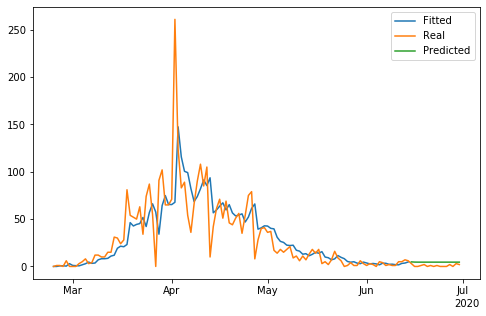

In [28]:
fig, ax = plt.subplots(figsize=(8,5))
locator = mdates.AutoDateLocator(minticks=3)
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
ax.plot(model_fit.fittedvalues.index, model_fit.fittedvalues.values, label='Fitted')
ax.plot(tmp_df[compart].index, tmp_df[compart].values, label='Real')
ax.plot(test.index, yhat, label='Predicted')
plt.legend()
plt.show()

[]

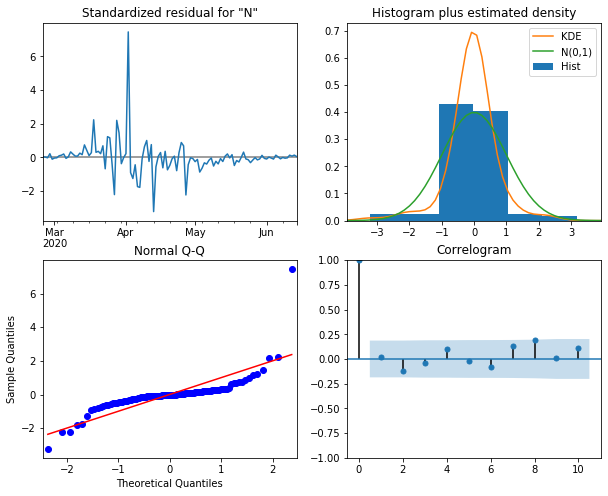

In [29]:
model_fit.plot_diagnostics(figsize=(10,8))
plt.plot()

In [30]:
mean_absolute_error(test, yhat), mean_squared_error(test, yhat)

(3.62600149768879, 14.270879987640232)

In [31]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              New_cases   No. Observations:                  112
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -519.168
Date:                Mon, 28 Dec 2020   AIC                           1044.335
Time:                        18:53:16   BIC                           1052.464
Sample:                    02-24-2020   HQIC                          1047.633
                         - 06-14-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1940      0.121      1.604      0.109      -0.043       0.431
ma.L1         -0.7784      0.086     -9.000      0.000      -0.948      -0.609
sigma2       672.3067     27.742     24.234      0.000     617.933     726.680
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):              3552.52
Prob(Q):                              0.84   Prob(JB):                         0.00
Heteroskedasticity (H):               0.06   Skew:                             3.34
Prob(H) (two-sided):                  0.00   Kurtosis:                        29.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [32]:
model_fit.conf_int()

0           1
ar.L1    -0.042979    0.430930
ma.L1    -0.947893   -0.608879
sigma2  617.933265  726.680153

### AR
#### Deseasonalized, detrended and stationary

In [ ]:
res = np.log(tmp_df[compart]) - np.log(tmp_df[compart]).shift(1)
res_fix = res.replace([np.inf, -np.inf], np.nan).interpolate(method='time')
res_fix.dropna(inplace=True)
decomposed = seasonal_decompose(res_fix, model='additive', extrapolate_trend='freq')
detrended = res_fix - decomposed.trend
deseasonalized = detrended / decomposed.seasonal

In [27]:
train = deseasonalized[:'20200614']
test = deseasonalized['20200615':]

In [68]:
# fit model
model = AutoReg(train, lags=1)
model_fit = model.fit()

# make prediction
yhat = model_fit.predict(test.index[0], test.index[-1])

/home/nick/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


In [69]:
mean_absolute_error(test, yhat), mean_squared_error(test, yhat)

(1.757172058276709, 10.663912731295468)

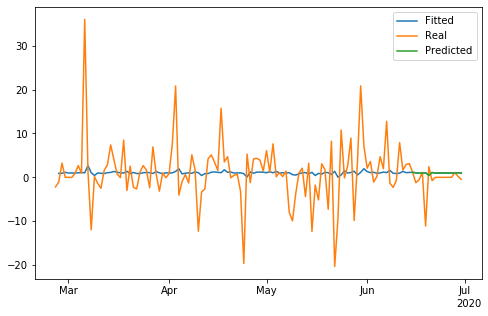

In [70]:
fig, ax = plt.subplots(figsize=(8,5))
locator = mdates.AutoDateLocator(minticks=3)
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
ax.plot(model_fit.fittedvalues.index, model_fit.fittedvalues.values, label='Fitted')
ax.plot(deseasonalized.index, deseasonalized.values, label='Real')
ax.plot(test.index, yhat, label='Predicted')
plt.legend()
plt.show()

[]

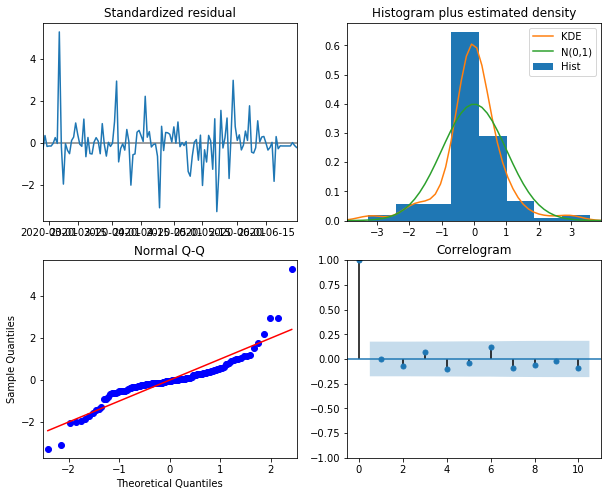

In [71]:
model_fit.plot_diagnostics(figsize=(10,8))
plt.plot()

In [72]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                      y   No. Observations:                  126
Model:                     AutoReg(1)   Log Likelihood                -413.555
Method:               Conditional MLE   S.D. of innovations              6.616
Date:                Mon, 28 Dec 2020   AIC                              3.827
Time:                        17:51:58   BIC                              3.895
Sample:                    02-27-2020   HQIC                             3.855
                         - 06-30-2020                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.9854      0.599      1.646      0.100      -0.188       2.159
y.L1           0.0469      0.089      0.526      0.599      -0.128       0.222
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           21.3123           +0.0000j           21.3123            0.0000
-----------------------------------------------------------------------------
"""

In [73]:
model_fit.diagnostic_summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
       Test of No Serial Correlation       
===========================================
       Lag  Ljung-Box LB P-value         DF
-------------------------------------------
         1      0.621      0.431          1
         2      1.275      0.529          2
         3      2.527      0.470          3
         4      2.731      0.604          4
         5      4.710      0.452          5
         6      5.795      0.447          6
         7      6.320      0.503          7
         8      6.398      0.603          8
         9      7.473      0.588          9
        10      7.534      0.674         10
        11      8.698      0.650         11


             Test of Normality              
============================================
Jarque-Bera    P-value   Skewness   Kurtosis
--------------------------------------------
    292.686      0.000      0.930     10.262


    Test of Conditional Homoskedasticity   
===========================================
       Lag    ARCH-LM    P-value         DF
-------------------------------------------
         1      0.096      0.757          1
         2      0.611      0.737          2
         3      1.248      0.741          3
         4      2.121      0.713          4
         5      2.413      0.790          5
         6      2.537      0.864          6
         7      3.003      0.885          7
         8      3.263      0.917          8
         9      9.438      0.398          9
        10     10.193      0.424         10
        11      8.402      0.677         11
        12      8.228      0.767         12
-------------------------------------------
"""

In [74]:
model_fit.conf_int()

0         1
intercept -0.188076  2.158854
y.L1      -0.128060  0.221903

### MA
#### Deseasonalized, detrended and stationary

In [75]:
model = ARIMA(train, order=(0, 0, 1))
model_fit = model.fit()

# make prediction
yhat = model_fit.predict(test.index[0], test.index[-1])

/home/nick/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/nick/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/nick/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


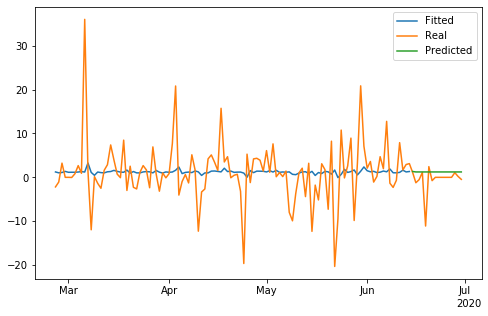

In [76]:
fig, ax = plt.subplots(figsize=(8,5))
locator = mdates.AutoDateLocator(minticks=3)
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
ax.plot(model_fit.fittedvalues.index, model_fit.fittedvalues.values, label='Fitted')
ax.plot(deseasonalized.index, deseasonalized.values, label='Real')
ax.plot(test.index, yhat, label='Predicted')
plt.legend()
plt.show()

[]

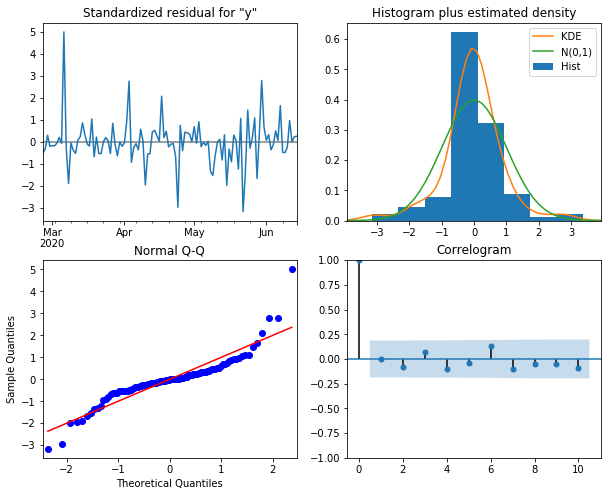

In [77]:
model_fit.plot_diagnostics(figsize=(10,8))
plt.plot()

In [78]:
mean_absolute_error(test, yhat), mean_squared_error(test, yhat)

(1.894738436825611, 11.226402830262469)

In [79]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  110
Model:                 ARIMA(0, 0, 1)   Log Likelihood                -369.261
Date:                Mon, 28 Dec 2020   AIC                            744.522
Time:                        17:52:00   BIC                            752.623
Sample:                    02-26-2020   HQIC                           747.808
                         - 06-14-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.2278      0.737      1.666      0.096      -0.216       2.672
ma.L1          0.0586      0.112      0.526      0.599      -0.160       0.277
sigma2        48.2271      3.326     14.502      0.000      41.709      54.745
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               203.11
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               1.21   Skew:                             0.88
Prob(H) (two-sided):                  0.57   Kurtosis:                         9.42
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [80]:
model_fit.conf_int()

0          1
const   -0.216423   2.672056
ma.L1   -0.159981   0.277204
sigma2  41.709039  54.745247

### ARMA
#### Deseasonalized, detrended and stationary

In [81]:
#ARMA
model = ARIMA(train, order=(2, 0, 1))
model_fit = model.fit()

# make prediction
yhat = model_fit.predict(test.index[0], test.index[-1])

/home/nick/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/nick/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/nick/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


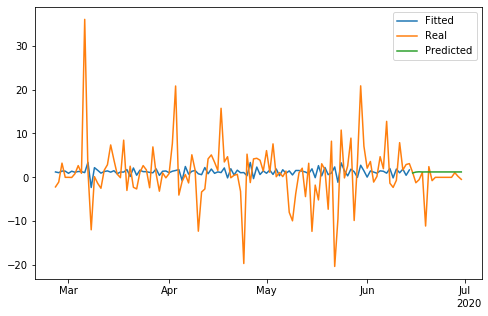

In [82]:
fig, ax = plt.subplots(figsize=(8,5))
locator = mdates.AutoDateLocator(minticks=3)
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
ax.plot(model_fit.fittedvalues.index, model_fit.fittedvalues.values, label='Fitted')
ax.plot(deseasonalized.index, deseasonalized.values, label='Real')
ax.plot(test.index, yhat, label='Predicted')
plt.legend()
plt.show()

[]

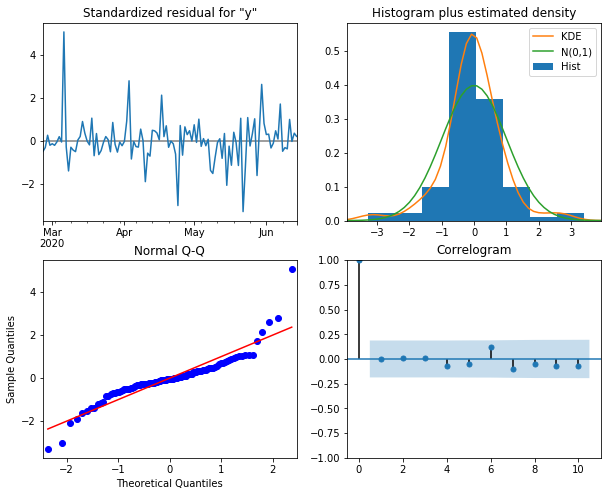

In [83]:
model_fit.plot_diagnostics(figsize=(10,8))
plt.plot()

In [84]:
mean_absolute_error(test, yhat), mean_squared_error(test, yhat)

(1.8902241050586515, 11.22901271432867)

In [85]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  110
Model:                 ARIMA(2, 0, 1)   Log Likelihood                -368.607
Date:                Mon, 28 Dec 2020   AIC                            747.213
Time:                        17:53:09   BIC                            760.715
Sample:                    02-26-2020   HQIC                           752.690
                         - 06-14-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.2285      0.698      1.759      0.079      -0.140       2.597
ar.L1         -0.4437      1.081     -0.410      0.681      -2.563       1.675
ar.L2         -0.0709      0.150     -0.474      0.635      -0.364       0.222
ma.L1          0.5034      1.122      0.449      0.654      -1.695       2.702
sigma2        47.6470      3.323     14.338      0.000      41.134      54.160
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               216.18
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               1.22   Skew:                             0.87
Prob(H) (two-sided):                  0.54   Kurtosis:                         9.64
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [86]:
model_fit.conf_int()

0          1
const   -0.140142   2.597186
ar.L1   -2.562510   1.675022
ar.L2   -0.364231   0.222360
ma.L1   -1.694703   2.701597
sigma2  41.133890  54.160118

### ARIMA
#### Deseasonalized, detrended and stationary

In [87]:
#ARIMA
model = ARIMA(train, order=(1, 1, 1))
model_fit = model.fit()

# make prediction
yhat = model_fit.predict(test.index[0], test.index[-1])

/home/nick/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/nick/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/nick/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


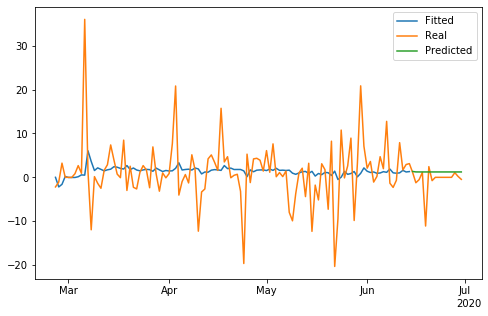

In [88]:
fig, ax = plt.subplots(figsize=(8,5))
locator = mdates.AutoDateLocator(minticks=3)
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
ax.plot(model_fit.fittedvalues.index, model_fit.fittedvalues.values, label='Fitted')
ax.plot(deseasonalized.index, deseasonalized.values, label='Real')
ax.plot(test.index, yhat, label='Predicted')
plt.legend()
plt.show()

[]

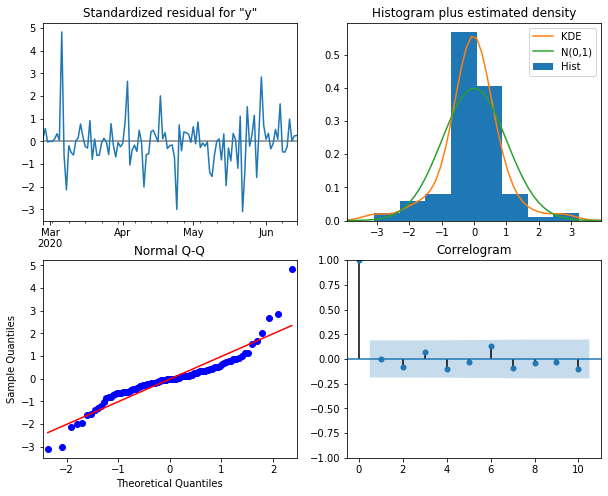

In [89]:
model_fit.plot_diagnostics(figsize=(10,8))
plt.plot()

In [90]:
mean_absolute_error(test, yhat), mean_squared_error(test, yhat)

(1.8951237943879946, 11.227053295988723)

In [91]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  110
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -368.723
Date:                Mon, 28 Dec 2020   AIC                            743.445
Time:                        17:53:15   BIC                            751.519
Sample:                    02-26-2020   HQIC                           746.720
                         - 06-14-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0585      0.109      0.538      0.591      -0.155       0.272
ma.L1         -0.9992      0.589     -1.696      0.090      -2.154       0.156
sigma2        48.7290     28.428      1.714      0.087      -6.988     104.446
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               161.30
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               1.14   Skew:                             0.78
Prob(H) (two-sided):                  0.69   Kurtosis:                         8.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [92]:
model_fit.conf_int()

0           1
ar.L1  -0.154788    0.271799
ma.L1  -2.154180    0.155689
sigma2 -6.988208  104.446185

### SARIMAX

In [19]:
# setting initial values and some bounds for them
from itertools import product

ps = list(range(2, 5)) + [28]
d=1 
qs = list(range(2, 5)) + [28]
Ps = range(0, 2)
D=1 
Qs = range(0, 2)
s = 7 # season length is 7

# creating list with all the possible combinations of parameters
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

64

In [29]:
from tqdm import tqdm

def optimizeSARIMA(data, parameters_list, d, D, s):
    """
        Return dataframe with parameters and corresponding AIC
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order in ARIMA model
        D - seasonal integration order 
        s - length of season
    """
    
    results = []
    best_aic = float("inf")

    for param in tqdm(parameters_list):
        # we need try-except because on some combinations model fails to converge
        try:
            model=sm.tsa.statespace.SARIMAX(data, order=(param[0], d, param[1]), 
                                            seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
        aic = model.aic
        # saving best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    # sorting in ascending order, the lower AIC is - the better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

In [67]:
import warnings
warnings.filterwarnings('ignore')

In [31]:
result_table = optimizeSARIMA(deseasonalized, parameters_list, d, D, s)

100%|██████████| 64/64 [07:31<00:00,  7.05s/it]


In [75]:
warnings.filterwarnings('default')

In [39]:
result_table.head()

parameters         aic
0  (2, 3, 1, 1)  817.105015
1  (2, 2, 1, 1)  817.170147
2  (2, 4, 1, 1)  818.543111
3  (3, 2, 1, 1)  818.644448
4  (3, 3, 1, 1)  818.823863

In [20]:
#p, q, P, Q = result_table.parameters[0]
p, q, P, Q = (2, 3, 1, 1)

best_results = sm.tsa.statespace.SARIMAX(deseasonalized, order=(p, d, q), 
                                        seasonal_order=(P, D, Q, s)).fit(disp=-1)
print(best_results.summary())

/home/nick/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/nick/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  126
Model:             SARIMAX(2, 1, 3)x(1, 1, [1], 7)   Log Likelihood                -400.553
Date:                             Fri, 11 Dec 2020   AIC                            817.105
Time:                                     16:11:14   BIC                            839.270
Sample:                                 02-26-2020   HQIC                           826.

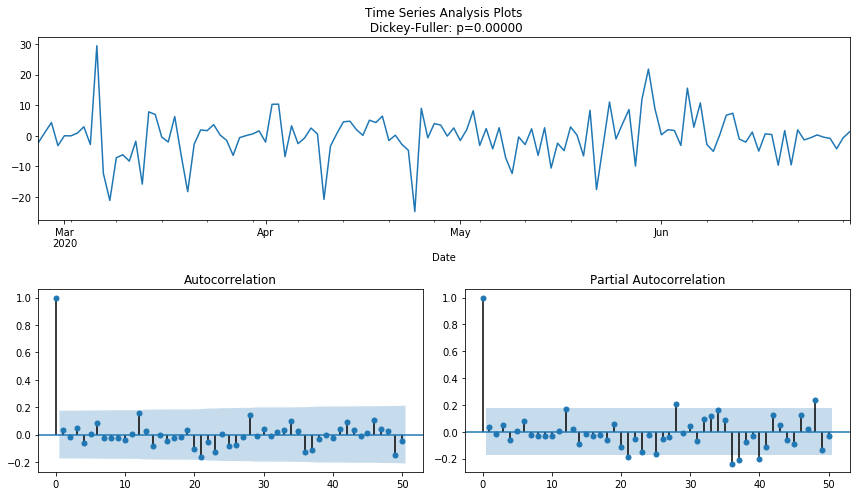

In [21]:
tsplot(best_results.resid, lags=50)

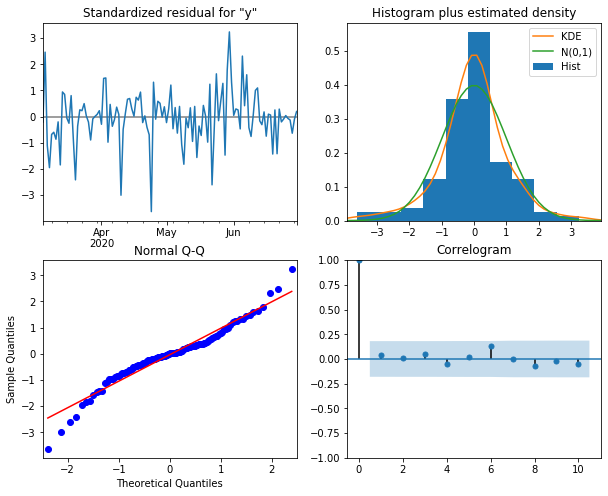

In [22]:
best_results.plot_diagnostics(figsize=(10,8))
plt.show()

In [23]:
best_results.conf_int()

0           1
ar.L1     -1.711645   -1.336380
ar.L2     -1.059836   -0.757594
ma.L1    -13.921534   15.160256
ma.L2    -24.346197   23.082654
ma.L3    -15.566891   13.592808
ar.S.L7   -0.411464   -0.090980
ma.S.L7   -0.829505   -0.518677
sigma2  -604.528511  692.848032

In [24]:
print("MAE:", best_results.mae)
print("MSE:", best_results.mse)
print("SSE:", best_results.sse)

MAE: 4.981802952314746
MSE: 54.63265256729769
SSE: 6883.714223479509


In [25]:
def plotSARIMA(y_train, y_test, model, s, d):
    """
        Plots model vs predicted values
        
        series - dataset with timeseries
        model - fitted SARIMA model
        n_steps - number of steps to predict in the future
        
    """
    # adding model values
    fitted = model.fittedvalues[s+d:].copy()
    real = y_train[s+d:].copy()

    real_plus_test = pd.concat([real, y_test])
    forecast = model.predict(start=real.index[-1], end=real_plus_test.index[-1])
    fitted_plus_prediction = pd.concat([fitted, forecast])

    fig, ax = plt.subplots(figsize=(15, 7))
    locator = mdates.AutoDateLocator(minticks=3)
    formatter = mdates.ConciseDateFormatter(locator)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)
    ax.plot(fitted_plus_prediction, label="model")
    plt.axvspan(fitted.index[-1], fitted_plus_prediction.index[-1], alpha=0.5, color='lightgrey')
    ax.plot(real_plus_test, label="actual")

    #plt.figure(figsize=(15, 7))
    #plt.plot(fitted_plus_prediction, label="model")
    #plt.axvspan(fitted.index[-1], fitted_plus_prediction.index[-1], alpha=0.5, color='lightgrey')
    #plt.plot(real_plus_test, label="actual")
    plt.legend(loc='upper right')
    plt.show()

In [26]:
test_df = covidpro_df[covidpro_df.Province == province].query('20200715 > Date >= 20200701')
test_df[compart] = test_df[compart].apply(lambda x: 0 if x is np.nan or x < 0 else x)
test_df = test_df.set_index(date)

test_df = test_df[[compart]]

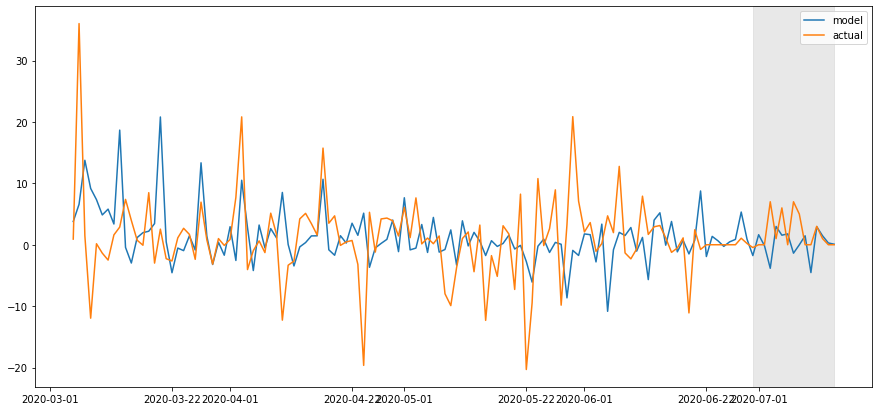

In [27]:
plotSARIMA(deseasonalized, test_df[[compart]][compart], best_results, s, d)

## Auto-SARIMAX

In [59]:
import pmdarima as pm
from pmdarima.arima.utils import nsdiffs, ndiffs
from pmdarima.arima import ADFTest
from pmdarima import model_selection

/home/nick/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [31]:
adf_test = ADFTest()
adf_test.should_diff(tmp_df[compart])

(0.552244669974572, True)

In [34]:
ndiffs(tmp_df[compart], test='adf', max_d=5), ndiffs(tmp_df[compart], test='kpss', max_d=5)

(1, 1)

In [21]:
nsdiffs(
    tmp_df[compart],
    m=7,
    max_D=30,
    test='ch')

0

In [22]:
nsdiffs(
    tmp_df[compart],
    m=7,
    max_D=30,
    test='ocsb')

0

In [38]:
smodel = pm.auto_arima(train, start_p=1, start_q=1,
                         test='adf',
                         max_p=14, max_q=14, m=7,
                         start_P=0, seasonal=True,
                         trace=True,
                         d=1, D=0,
                         stepwise=True, n_jobs=-1)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,1)[7] intercept   : AIC=966.720, Time=0.78 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=993.029, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=987.302, Time=0.28 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=967.243, Time=0.36 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=991.029, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[7] intercept   : AIC=967.654, Time=0.10 sec
 ARIMA(1,1,1)(1,0,1)[7] intercept   : AIC=963.649, Time=1.03 sec
 ARIMA(1,1,1)(1,0,0)[7] intercept   : AIC=965.673, Time=0.50 sec
 ARIMA(1,1,1)(2,0,1)[7] intercept   : AIC=965.111, Time=0.76 sec
 ARIMA(1,1,1)(1,0,2)[7] intercept   : AIC=964.961, Time=0.85 sec
 ARIMA(1,1,1)(0,0,2)[7] intercept   : AIC=966.296, Time=0.91 sec
 ARIMA(1,1,1)(2,0,0)[7] intercept   : AIC=964.572, Time=0.93 sec
 ARIMA(1,1,1)(2,0,2)[7] intercept   : AIC=inf, Time=3.51 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=964.281, Time=0.83 sec
 ARIMA(1,1,0)(1,0,1)[7] intercept   : AIC=984.296, 

In [39]:
smodel.summary()

/home/nick/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  112
Model:             SARIMAX(3, 1, 2)x(1, 0, [1], 7)   Log Likelihood                -468.917
Date:                             Thu, 21 Jan 2021   AIC                            953.834
Time:                                     23:51:11   BIC                            975.510
Sample:                                          0   HQIC                           962.628
                                             - 112                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6596      0.125     -5.296      0.000      -0.904      -0.415
ar.L2         -0.1812      0.146     -1.243      0.214      -0.467       0.105
ar.L3         -0.3772      0.091     -4.162      0.000      -0.555      -0.200
ma.L1          0.1305      0.141      0.923      0.356      -0.147       0.408
ma.L2         -0.4645      0.152     -3.051      0.002      -0.763      -0.166
ar.S.L7        0.7292      0.287      2.540      0.011       0.166       1.292
ma.S.L7       -0.5197      0.355     -1.466      0.143      -1.214       0.175
sigma2       269.0046     21.422     12.558      0.000     227.019     310.990
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               128.44
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               0.06   Skew:                            -0.61
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

[]

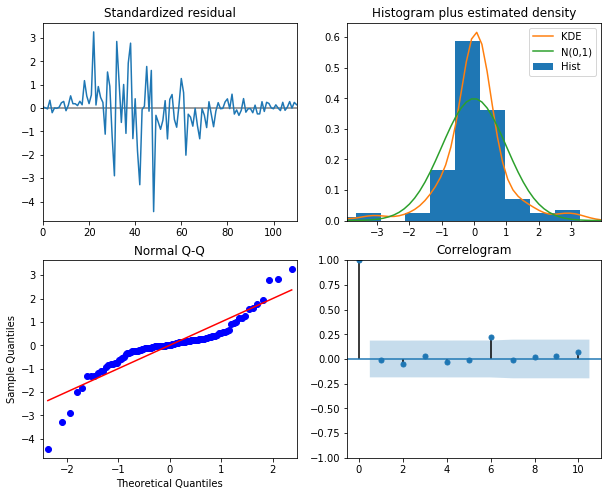

In [41]:
smodel.plot_diagnostics(figsize=(10,8))
plt.plot()

In [47]:
yhat, ci = smodel.predict(n_periods=len(test), return_conf_int=True)

/home/nick/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [48]:
mean_absolute_error(test, yhat), mean_squared_error(test, yhat)

/home/nick/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(3.076240754327265, 11.238184494484766)

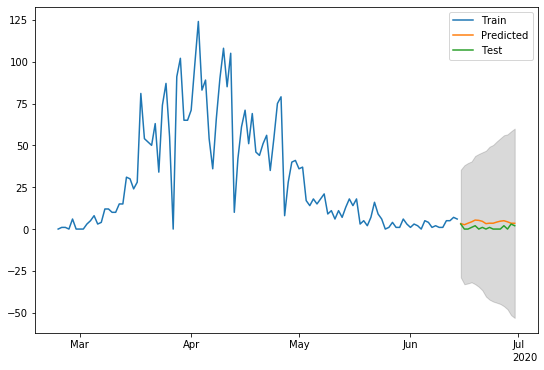

In [54]:
lower_series = pd.Series(ci[:, 0], index=test.index)
upper_series = pd.Series(ci[:, 1], index=test.index)

fig, ax = plt.subplots(figsize=(9,6))
locator = mdates.AutoDateLocator(minticks=3)
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
ax.plot(train.index, train.values, label='Train')
ax.plot(test.index, yhat, label='Predicted')
ax.plot(test.index, test.values, label='Test')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)
plt.legend()
plt.show()

In [56]:
smodel.order, smodel.seasonal_order

/home/nick/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


((3, 1, 2), (1, 0, 1, 7))

/home/nick/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[CV] fold=0 ..........................................................
[CV] fold=1 ..........................................................
[CV] fold=2 ..........................................................
[CV] fold=3 ..........................................................
[CV] fold=4 ..........................................................
[CV] fold=5 ..........................................................
[CV] fold=6 ..........................................................
[CV] fold=7 ..........................................................
[CV] fold=8 ........................................................

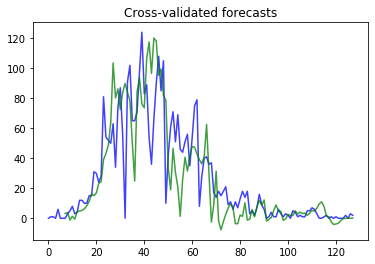

In [61]:
est = pm.ARIMA(order=smodel.order,
               seasonal_order=smodel.seasonal_order,
               suppress_warnings=True)
cv = model_selection.SlidingWindowForecastCV(window_size=7, step=1, h=7)
predictions = model_selection.cross_val_predict(
    est, tmp_df[compart], cv=cv, verbose=2, averaging="median")

# plot the predictions over the original series
x_axis = np.arange(tmp_df[compart].shape[0])
n_test = predictions.shape[0]

plt.plot(x_axis, tmp_df[compart], alpha=0.75, c='b')
plt.plot(x_axis[-n_test:], predictions, alpha=0.75, c='g')  # Forecasts
plt.title("Cross-validated forecasts")
plt.show()

In [62]:
model1_cv_scores = model_selection.cross_val_score(
    smodel, test, scoring='mean_squared_error', cv=cv, verbose=2)

/home/nick/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[CV] fold=0 ..........................................................
[CV] fold=1 ..........................................................
[CV] fold=2 ..........................................................


In [63]:
model1_cv_scores

/home/nick/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([1.25279535, 0.58223369, 1.08500275])

In [64]:
np.average(model1_cv_scores)

0.9733439315665073

## Time series as Supervised classification

In [71]:
tmp_df = covidpro_df[covidpro_df.Province == province].query('20200801 > Date')
tmp_df[compart] = tmp_df[compart].apply(lambda x: 0 if x is np.nan or x < 0 else x)
tmp_df = tmp_df.set_index(date)

tmp_df = tmp_df[[compart]]

In [72]:
data = pd.DataFrame(tmp_df[compart].copy())

In [73]:
data.columns = ["y"]
data["weekday"] = data.index.weekday

In [74]:
for i in range(1, 30):
    data["lag_{}".format(i)] = data.y.shift(i)

In [75]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, TimeSeriesSplit

# for time-series cross-validation set 5 folds 
tscv = TimeSeriesSplit(n_splits=5)

In [76]:
def timeseries_train_test_split(X, y, test_size):
    """
        Perform train-test split with respect to time series structure
    """
    
    # get the index after which test set starts
    test_index = int(len(X)*(1-test_size))
    
    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]
    
    return X_train, X_test, y_train, y_test

In [77]:
y = data.dropna().y
X = data.dropna().drop(['y'], axis=1)

# reserve 30% of data for testing
X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)

In [78]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [81]:
def plotModelResults(model, X_train=X_train, X_test=X_test, plot_intervals=False, plot_anomalies=False):
    """
        Plots modelled vs fact values, prediction intervals and anomalies
    
    """
    
    prediction = model.predict(X_test)
    
    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)
    
    if plot_intervals:
        cv = cross_val_score(model, X_train, y_train, 
                                    cv=tscv, 
                                    scoring="neg_mean_absolute_error")
        mae = cv.mean() * (-1)
        deviation = cv.std()
        
        scale = 1.96
        lower = prediction - (mae + scale * deviation)
        upper = prediction + (mae + scale * deviation)
        
        plt.plot(lower, "r--", label="upper bound / lower bound", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)
        
        if plot_anomalies:
            anomalies = np.array([np.NaN]*len(y_test))
            anomalies[y_test<lower] = y_test[y_test<lower]
            anomalies[y_test>upper] = y_test[y_test>upper]
            plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    error = mean_squared_error(prediction, y_test)
    plt.title("Mean squared error {0:.2f}%".format(error))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.show()
    
def plotCoefficients(model):
    """
        Plots sorted coefficient values of the model
    """
    
    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    
    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind='bar')
    #plt.grid(True, axis='y')
    #plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed')
    plt.hlines(y=0, xmax=len(coefs))
    plt.show()

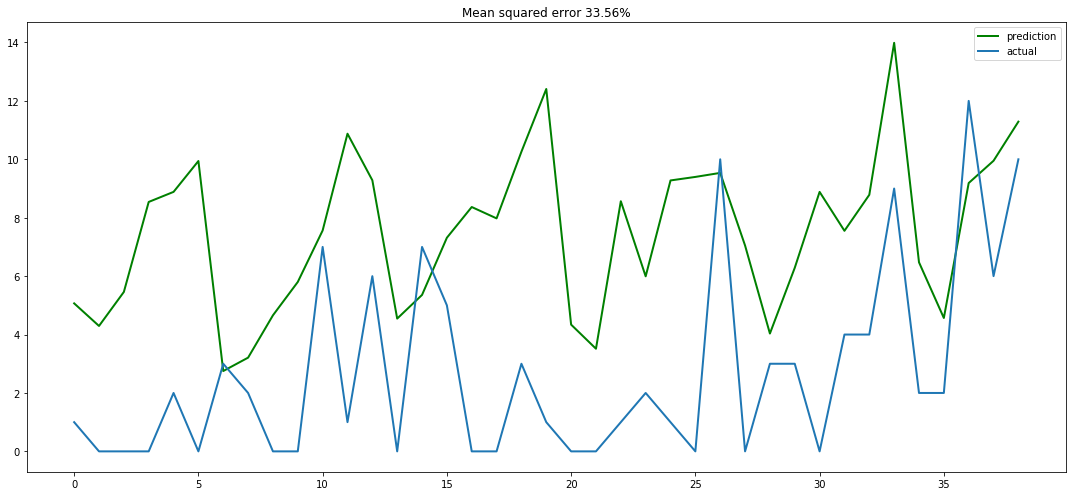

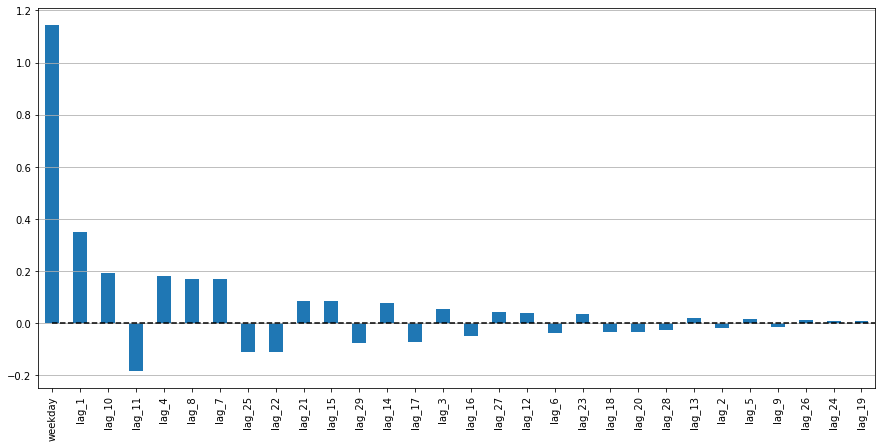

In [82]:
plotModelResults(lr)
plotCoefficients(lr)

In [83]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

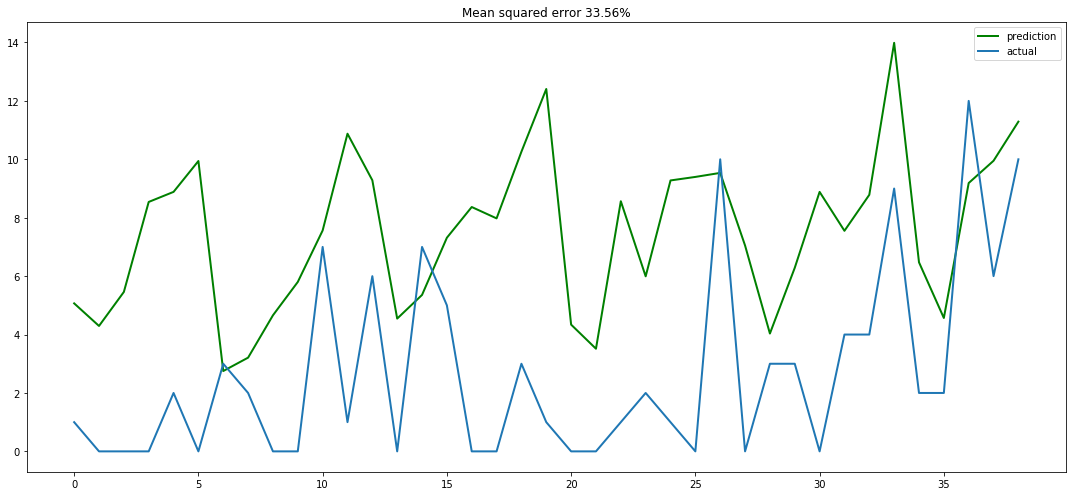

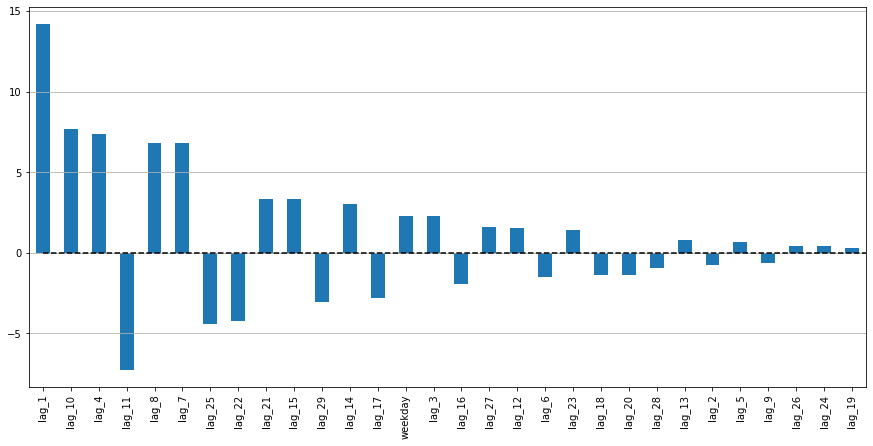

In [84]:
y = data.dropna().y
X = data.dropna().drop(['y'], axis=1)

X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

plotModelResults(lr, X_train=X_train_scaled, X_test=X_test_scaled)
plotCoefficients(lr)

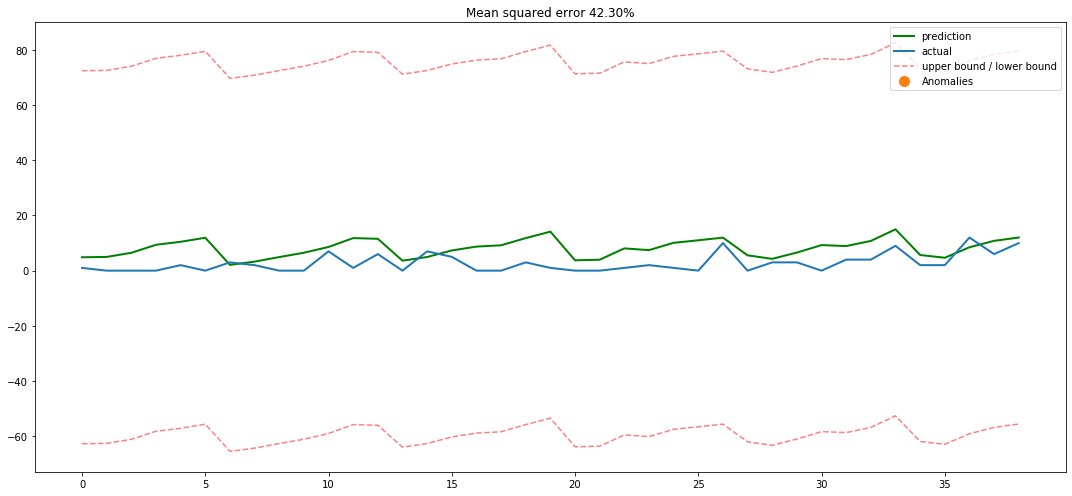

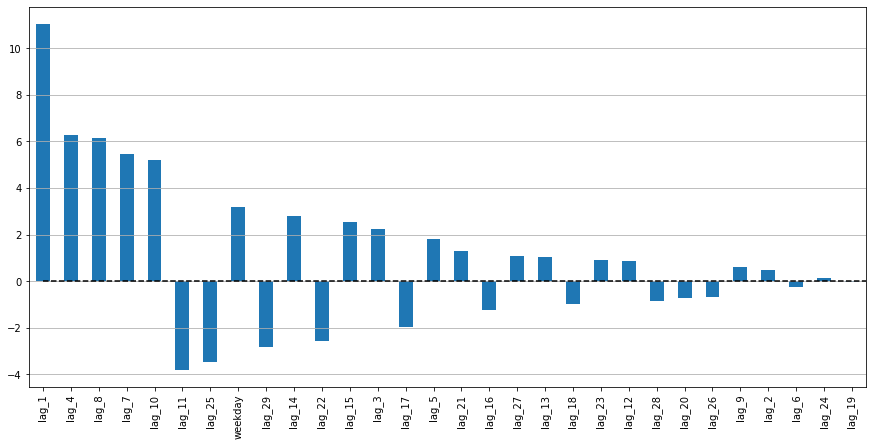

In [85]:
from sklearn.linear_model import LassoCV, RidgeCV

ridge = RidgeCV(cv=tscv)
ridge.fit(X_train_scaled, y_train)

plotModelResults(ridge, 
                 X_train=X_train_scaled, 
                 X_test=X_test_scaled, 
                 plot_intervals=True, plot_anomalies=True)
plotCoefficients(ridge)

In [88]:
from xgboost import XGBRegressor 

xgb = XGBRegressor()
xgb.fit(X_train_scaled, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

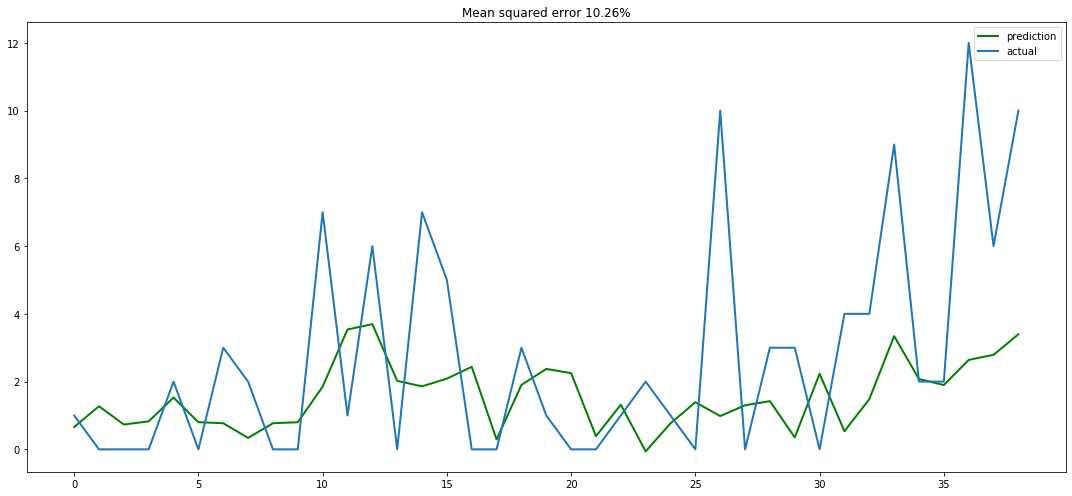

In [90]:
plotModelResults(xgb, 
                 X_train=X_train_scaled, 
                 X_test=X_test_scaled)